# Import

In [1]:
pip install dataframe-image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 385.7/385.7 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.9/45.9 MB 16.7 MB/s eta 0:00:00


In [2]:
pip install "kaleido==0.1.0"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 MB 12.2 MB/s eta 0:00:00


In [3]:
# Data handling and preprocessing
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from math import pi
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap, Normalize
from IPython.display import display
import dataframe_image as dfi

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Functions

In [13]:
def plot_dipole_chart(df, sensitive_feature_cols, technique_order, score_col='Score'):
    """
    Generates a dipole bar chart comparing scores across two sensitive features.

    Args:
        df (pd.DataFrame): DataFrame containing technique scores by sensitive feature.
        sensitive_feature_cols (dict): A dictionary mapping sensitive feature names
                                       to their desired column names in the pivoted data.
                                       Example: {'Age': 'Age Score', 'Sex': 'Sex Score'}
        score_col (str): The name of the column containing the score values.
                         Defaults to 'Score'.
    """
    # Normalize scores by sensitive feature
    df['Raw Score'] = df[score_col]
    df['Normalized Score'] = df.groupby('Sensitive Feature')[score_col].transform(
        lambda x: (x - x.min()) / (x.max() - x.min()) if x.max() != x.min() else np.zeros_like(x)
    )

    # Pivot the data for the dipole chart
    raw_data = df.pivot(index='Technique', columns='Sensitive Feature', values='Raw Score').reset_index()
    norm_data = df.pivot(index='Technique', columns='Sensitive Feature', values='Normalized Score').reset_index()

    # Rename columns for clarity
    raw_data = raw_data.rename(columns=sensitive_feature_cols)
    norm_data = norm_data.rename(columns={k: v + '_Norm' for k, v in sensitive_feature_cols.items()})

    #Merge raw and normalized pivoted data
    dipole_data = pd.merge(raw_data, norm_data, on='Technique')

    # Ensure the order of techniques is consistent
    dipole_data['Technique'] = pd.Categorical(dipole_data['Technique'], categories=technique_order, ordered=True)
    dipole_data = dipole_data.sort_values('Technique')

    # Create the dipole chart
    fig, axes = plt.subplots(1, 2, figsize=(8, 5), sharey=True)

    # Plot for the first sensitive feature (left side)
    sf1 = list(sensitive_feature_cols.values())[0]
    sf1_norm = sf1 + '_Norm'
    sns.barplot(x=sf1, y='Technique', data=dipole_data, ax=axes[0], color='#167F62')
    axes[0].set_title(f'{sf1}')
    axes[0].invert_xaxis()
    axes[0].set_xlabel('Total Score (Better)')
    axes[0].set_ylabel('Technique')

    # Plot for the second sensitive feature (right side)
    sf2 = list(sensitive_feature_cols.values())[1]
    sf2_norm = sf2 + '_Norm'
    sns.barplot(x=sf2, y='Technique', data=dipole_data, ax=axes[1], color='#C00000')
    axes[1].set_title(f'{sf2}')
    axes[1].yaxis.tick_right()
    axes[1].set_xlabel('Total Score (Better)')
    axes[1].set_ylabel('')

    # Add annotations to the bars
    for i, p in enumerate(axes[0].patches):
        axes[0].text(
            p.get_width() * 0.95,
            p.get_y() + p.get_height()/2,
            f"{dipole_data[sf1].iloc[i]:.0f} ({dipole_data[sf1_norm].iloc[i]:.2f})",
            ha='left', va='center', color='white', weight='bold'
        )

    for i, p in enumerate(axes[1].patches):
        axes[1].text(
            p.get_width() * 0.95,
            p.get_y() + p.get_height()/2,
            f"{dipole_data[sf2].iloc[i]:.0f} ({dipole_data[sf2_norm].iloc[i]:.2f})",
            ha='right', va='center', color='white', weight='bold'
        )

    plt.suptitle('Dipole Chart of Technique Scores by Sensitive Feature')
    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to prevent title overlap
    plt.show()

In [14]:
def score_row(row):
    metric = row["Metric"]
    delta = row["Δ Score"]

    if pd.isna(delta):
        return 0

    if metric in ["Acc", "F1", "ROC"]:
        return max(0, delta / 0.01)
    else:  # fairness metrics
        return max(0, delta / 0.01)

In [15]:
# Function to compute deltas

def compute_deltas(df, metrics):
    baseline_cols = {
        metric: col for metric in metrics
        for col in df.columns if col.strip() == f"Baseline {metric}"
    }
    baseline_df = df[["Version"] + list(baseline_cols.values())].copy()
    baseline_df.columns = ["Version"] + metrics

    delta_records = []
    for col in df.columns:
        if "Baseline " in col or col.startswith("Unnamed") or col in ["Data", "Technique"]:
            continue

        for metric in metrics:
            if col.endswith(f" {metric}"):
                technique_name = col.replace(f" {metric}", "")
                for idx, row in df.iterrows():
                    dataset = row["Version"]
                    sensitive_feature = row["Sensitive Feature"]
                    technique_score = pd.to_numeric(row[col], errors='coerce')
                    baseline_score = pd.to_numeric(baseline_df.loc[idx, metric], errors='coerce')

                    if pd.isna(technique_score) or pd.isna(baseline_score):
                        delta = np.nan
                        delta_perc = np.nan
                        polarity_flip = False
                    elif metric in ["Acc", "F1", "ROC"]:
                        delta = technique_score - baseline_score
                        delta_perc = delta / baseline_score if baseline_score != 0 else np.nan
                        polarity_flip = False  # Polarity check is not needed for performance metrics
                    elif metric in ["DI"]:  # closer to 1 is better
                        delta = abs(1 - baseline_score) - abs(1 - technique_score)
                        delta_perc = delta / abs(1 - baseline_score) if baseline_score != 0 else np.nan
                        polarity_flip = False  # Polarity check is not needed
                    else:
                        delta = abs(baseline_score) - abs(technique_score)
                        delta_perc = delta / abs(baseline_score) if baseline_score != 0 else np.nan
                        # Check polarity (signs are opposite)
                        polarity_flip = (np.sign(baseline_score) != np.sign(technique_score)) and \
                                        (baseline_score != 0 and technique_score != 0)

                    delta_records.append({
                        "Data": dataset,
                        "Sensitive Feature": sensitive_feature,
                        "Technique": technique_name,
                        "Metric": metric,
                        "Δ Score": delta,
                        "Δ %": delta_perc*100,
                        "Polarity Flip": polarity_flip
                    })
    # Make delta_records into a df
    delta_df = pd.DataFrame(delta_records)

    return delta_df

In [16]:
def plot_individual_deltas(delta_df, technique_order, metrics):
    # Custom colormap: green = better, red = worse
    green_red_cmap = LinearSegmentedColormap.from_list("green_red", ["#C00000", "white", "#167F62"])

    # Get unique (dataset, sensitive feature) pairs
    groups = delta_df[["Data", "Sensitive Feature"]].drop_duplicates()

    for _, row in groups.iterrows():
        dataset = row["Data"]
        sens_feat = row["Sensitive Feature"]

        # Filter data
        subset = (
            delta_df[(delta_df["Data"] == dataset) & (delta_df["Sensitive Feature"] == sens_feat)]
            .groupby(["Technique", "Metric"])["Δ Score"]
            .mean()
            .reset_index()
        )

        # Pivot: Techniques x Metrics with adjusted deltas
        heatmap_data = subset.pivot(index="Technique", columns="Metric", values="Δ Score")

        # Reindex to enforce row and column order
        heatmap_data = heatmap_data.reindex(index=technique_order, columns=metrics)

        # === Build custom annotations with Δ and % change ===
        annot_array = heatmap_data.copy().astype(str)

        for i in range(heatmap_data.shape[0]):       # loop over techniques
            for j in range(heatmap_data.shape[1]):   # loop over metrics
                val = heatmap_data.iloc[i, j]
                if pd.isna(val):
                    annot_array.iloc[i, j] = ""
                else:
                    # raw delta
                    delta_val = f"{val:.2f}"

                    # percentage relative to baseline (match dataset + sens + technique + metric)
                    perc_match = delta_df.loc[
                        (delta_df["Data"] == dataset) &
                        (delta_df["Sensitive Feature"] == sens_feat) &
                        (delta_df["Technique"] == technique_order[i]) &
                        (delta_df["Metric"] == metrics[j]),
                        "Δ %"
                    ]
                    polarity_flip = delta_df.loc[
                        (delta_df["Data"] == dataset) &
                        (delta_df["Sensitive Feature"] == sens_feat) &
                        (delta_df["Technique"] == technique_order[i]) &
                        (delta_df["Metric"] == metrics[j]),
                        "Polarity Flip"
                    ].iloc[0] # Access scalar value

                    if not perc_match.empty:
                        delta_perc = f"{perc_match.values[0]:.0f}"
                        if polarity_flip == False:
                            annot_array.iloc[i, j] = f"{delta_val}\n({delta_perc}%)"
                        else:
                            annot_array.iloc[i, j] = f"{delta_val}\n({delta_perc}% ⇅)"
                    else:
                        annot_array.iloc[i, j] = f"{delta_val}\n(?)"

        # Plot
        plt.figure(figsize=(8, len(heatmap_data) * 0.4 + 2))
        sns.heatmap(
            heatmap_data,
            annot=annot_array,
            fmt="",
            cmap=green_red_cmap,
            center=0,
            linewidths=0.5,
            linecolor="grey",
            cbar_kws={"label": "Δ Score (Green = Better, Red = Worse)"}
        )

        plt.title(f"Δ Score vs Baseline\nDataset: {dataset} | Sensitive Feature: {sens_feat}")
        plt.xlabel("Metric")
        plt.ylabel("Technique")
        plt.xticks(rotation=0)
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

In [17]:
import textwrap
def plot_combined_scores(name, delta_df, technique_order, row_height=0.5):
    # Apply scoring
    delta_df["Score"] = delta_df.apply(score_row, axis=1)

    # Exclude F1 and ROC for bar + line plots
    filtered_df = delta_df[~delta_df["Metric"].isin(["F1", "ROC"])].copy()

    # Normalised score (row-wise, per dataset)
    delta_df["Norm_Score"] = delta_df.groupby("Data")["Score"].transform(
        lambda x: (x - x.min()) / (x.max() - x.min()) if x.max() != x.min() else 0
    )

    # Normalised score (row-wise, per dataset, for filtered metrics)
    filtered_df["Norm_Score"] = filtered_df.groupby("Data")["Score"].transform(
        lambda x: (x - x.min()) / (x.max() - x.min()) if x.max() != x.min() else 0
    )

    # ----- COMBINED TABLE -----
    combined_rows = []
    for sens_feat in delta_df["Sensitive Feature"].unique():
        filtered = delta_df[delta_df["Sensitive Feature"] == sens_feat]
        score_df = filtered.groupby(["Data", "Technique"], as_index=False).agg(
            {"Score": "sum", "Norm_Score": "mean"}
        )
        score_matrix = score_df.pivot(index="Data", columns="Technique", values="Score")
        norm_matrix = score_df.pivot(index="Data", columns="Technique", values="Norm_Score")
        score_matrix = score_matrix.reindex(columns=technique_order)
        norm_matrix = norm_matrix.reindex(columns=technique_order)

        for idx, row in score_matrix.iterrows():
            annot_row = [sens_feat, idx]  # first two columns
            for tech in score_matrix.columns:
                norm_val = norm_matrix.loc[idx, tech]
                score_val = score_matrix.loc[idx, tech]
                annot_row.append(f"{norm_val:.1f} ({score_val:.0f})")
            combined_rows.append(annot_row)

    col_labels = ["Sensitive Feature", "Dataset"] + list(score_matrix.columns)


    fig_height = max(len(combined_rows) * row_height, 3)
    fig, ax = plt.subplots(figsize=(12, fig_height))

    ax.axis('off')

    table = ax.table(
        cellText=combined_rows,
        colLabels=col_labels,
        loc='center',
        cellLoc='center'
    )

    # Adjust column widths to match text length
    for i, col in enumerate(col_labels):
        table.auto_set_column_width(i)

    # Color cells by score
    green_cmap = LinearSegmentedColormap.from_list("green_white", ["white", "#167F62"])
    all_scores = [float(cell.split("(")[1].replace(")", "")) for row in combined_rows for cell in row[2:]]
    norm = Normalize(vmin=min(all_scores), vmax=max(all_scores))

    for i, row in enumerate(combined_rows):
        for j, cell_text in enumerate(row[2:], start=2):
            cell = table.get_celld()[(i + 1, j)]
            score_val = float(cell_text.split("(")[1].replace(")", ""))
            cell.set_facecolor(green_cmap(norm(score_val)))

    table.auto_set_font_size(False)
    table.scale(0.8, 1.8)

    ax.set_title(
        f"{name}: Technique Scores Across All Sensitive Features",
        fontsize=14,
    )

    for (row, col), cell in table.get_celld().items():
        if row == 0:  # header row
            cell.set_text_props(weight='bold')

    plt.tight_layout()
    plt.show()

    # ----- COMBINED BAR CHART -----
    total_scores = filtered_df.groupby(["Sensitive Feature", "Technique"])["Score"].sum().reset_index()

    # Order techniques
    total_scores["Technique"] = pd.Categorical(total_scores["Technique"], categories=technique_order, ordered=True)
    total_scores = total_scores.sort_values(["Sensitive Feature", "Technique"])

    plt.figure(figsize=(10, 6))

    ax = sns.barplot(
        x='Technique',
        y='Score',
        hue='Sensitive Feature',
        data=total_scores,
        palette='viridis'
    )

    # Add labels on bars
    for p in ax.patches:
        ax.annotate(
            f'{p.get_height():.0f}',
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='bottom',
            fontsize=9, color='black',
            xytext=(0, 3),
            textcoords='offset points'
        )

    plt.title("Total Score per Technique Across Sensitive Features")
    plt.xlabel("Technique")
    plt.ylabel("Total Score")
    plt.xticks(rotation=45, ha='right')
    plt.legend(title="Sensitive Feature")
    plt.tight_layout()
    plt.show()

    # ----- LINE PLOTS PER SENSITIVE FEATURE (unchanged) -----
    for sens_feat in filtered_df["Sensitive Feature"].unique():
        filtered_line = filtered_df[filtered_df["Sensitive Feature"] == sens_feat]
        score_df_line = filtered_line.groupby(["Data", "Technique"], as_index=False).agg(
            {"Score": "sum", "Norm_Score": "mean"}
        )
        plt.figure(figsize=(14, 6))
        for tech in technique_order:
            if tech in score_df_line["Technique"].unique():
                tech_scores = score_df_line[score_df_line["Technique"] == tech]
                plt.plot(
                    tech_scores["Data"],
                    tech_scores["Norm_Score"],
                    marker="o",
                    label=tech,
                )
        # Wrap x-tick labels into multiple lines
        labels = score_df_line["Data"].unique()
        wrapped_labels = ["\n".join(textwrap.wrap(label, width=11)) for label in labels]
        plt.xticks(ticks=range(len(labels)), labels=wrapped_labels, rotation=0)

        plt.title(f"{name}: Normalised Technique Scores — Sensitive Feature: {sens_feat}")
        plt.xlabel("Dataset")
        plt.ylabel("Normalised Score (0–1)")
        #plt.xticks(rotation=90)
        plt.legend(title="Technique", bbox_to_anchor=(1.05, 1), loc="upper left")
        plt.tight_layout()
        plt.show()

In [36]:
def plot_combined_results_table(combined_pivot, technique_order, name="Combined Results", row_height=0.5, font_size=10):
    # Ensure technique columns exist in order
    cols = ['Dataset', 'Sensitive Feature'] + [t for t in technique_order if t in combined_pivot.columns]
    table_data = combined_pivot[cols]

    # Convert scores to strings for table cells
    annot_data = table_data.copy()
    for col in annot_data.columns[2:]:
        annot_data[col] = annot_data[col].apply(lambda x: f"{x:.0f}")

    # Create figure
    fig_height = max(len(table_data) * row_height, 3)
    fig, ax = plt.subplots(figsize=(12, fig_height))
    ax.axis('off')

    # Create table
    table = ax.table(
        cellText=annot_data.values,
        colLabels=annot_data.columns,
        loc='center',
        cellLoc='center'
    )


    # Define minimum width
    min_width = 0.002

    # Get target column indices (by name)
    target_cols = technique_order
    target_indices = [annot_data.columns.get_loc(col) for col in target_cols]

    # Apply only to those columns
    for i in target_indices:
        for j in range(len(annot_data) + 1):  # +1 for header row
            cell = table.get_celld()[(j, i)]
            if cell.get_width() < min_width:
                cell.set_width(min_width)

    # Scale row height
    table.scale(1, 1.8)
    table.auto_set_font_size(False)
    table.set_fontsize(font_size)

    # Heatmap coloring for score cells (skip first two columns)
    green_cmap = LinearSegmentedColormap.from_list("green_white", ["white", "#167F62"])
    '''
    all_scores = combined_pivot.iloc[:, 2:].values.flatten()
    norm = Normalize(vmin=np.min(all_scores), vmax=np.max(all_scores))

    for i in range(len(table_data)):
        for j, col in enumerate(annot_data.columns[2:], start=2):
            cell = table.get_celld()[(i + 1, j)]
            score_val = combined_pivot.iloc[i, j]
            cell.set_facecolor(green_cmap(norm(score_val)))
            '''
    # Filter out NaNs when computing min/max
    valid_scores = combined_pivot.iloc[:-1, 2:].values.flatten()  # exclude last row
    valid_scores = valid_scores[~np.isnan(valid_scores)]

    norm = Normalize(vmin=np.min(valid_scores), vmax=np.max(valid_scores))

    # Apply heatmap coloring (skip last row)
    for i in range(len(table_data) - 1):  # exclude last row
        for j, col in enumerate(annot_data.columns[2:], start=2):
            cell = table.get_celld()[(i + 1, j)]
            score_val = combined_pivot.iloc[i, j]

            if not np.isnan(score_val):  # ignore NaN cells
                cell.set_facecolor(green_cmap(norm(score_val)))
            else:
                cell.set_facecolor("white")

    # Last row in bold (including Dataset + Sensitive Feature + scores)
    last_row_idx = len(table_data)
    for col in range(len(annot_data.columns)):
        cell = table.get_celld()[(last_row_idx, col)]
        cell.set_text_props(weight='bold')

    # Add title manually closer to table
    fig.text(
        0.5, 1,  # centered horizontally, near top
        f"{name}: Technique Scores Across Datasets and Sensitive Features",
        ha='center', va='top',
        fontsize=14
    )

    for (row, col), cell in table.get_celld().items():
        if row == 0:  # header row
            cell.set_text_props(weight='bold')

    for (row, col), cell in table.get_celld().items():
        text = cell.get_text().get_text()
        wrapped = "\n".join(textwrap.wrap(text, width=10))
        cell.get_text().set_text(wrapped)

    plt.tight_layout()
    plt.show()

In [19]:
def plot_filtered_scores(delta_df, versions_to_exclude, technique_order):

    # Apply scoring
    delta_df["Score"] = delta_df.apply(score_row, axis=1)

    # Exclude F1 and ROC for bar + line plots
    filtered_df = delta_df[~delta_df["Metric"].isin(["F1", "ROC"])].copy()

    # Normalised score (row-wise, per dataset, for filtered metrics)
    filtered_df["Norm_Score"] = filtered_df.groupby("Data")["Score"].transform(
        lambda x: (x - x.min()) / (x.max() - x.min()) if x.max() != x.min() else 0
    )

    # Filter out excluded versions
    filtered_delta_df = filtered_df[~filtered_df['Data'].isin(versions_to_exclude)].copy()

    # Get the total score for each Technique, separated by Sensitive Feature
    total_scores_by_sensitive_feature = filtered_delta_df.groupby(["Sensitive Feature", "Technique"])["Score"].sum().reset_index()

    plot_scores_by_sensitive_feature(total_scores_by_sensitive_feature, technique_order)

    return total_scores_by_sensitive_feature


In [20]:
# Udpated function
def plot_scores_by_sensitive_feature(df, technique_order):

    # ----- COMBINED BAR CHART -----
    total_scores = df.groupby(["Sensitive Feature", "Technique"])["Score"].sum().reset_index()

    # Order techniques
    total_scores["Technique"] = pd.Categorical(total_scores["Technique"], categories=technique_order, ordered=True)
    total_scores = total_scores.sort_values(["Sensitive Feature", "Technique"])

    plt.figure(figsize=(10, 6))

    ax = sns.barplot(
        x='Technique',
        y='Score',
        hue='Sensitive Feature',
        data=total_scores,
        palette='viridis'
    )

    # Add labels on bars
    for p in ax.patches:
        ax.annotate(
            f'{p.get_height():.0f}',
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='bottom',
            fontsize=9, color='black',
            xytext=(0, 3),
            textcoords='offset points'
        )

    plt.title("Total Score per Technique Across Sensitive Features")
    plt.xlabel("Technique")
    plt.ylabel("Total Score")
    plt.xticks(rotation=45, ha='right')
    plt.legend(title="Sensitive Feature")
    plt.tight_layout()
    plt.show()


# Adult

In [21]:
# Define metrics for all Domains
performance_metrics = ["Acc", "F1", "ROC"]
fairness_metrics = ["SPD", "EOPD", "EOD", "AOD"]
metrics = performance_metrics + fairness_metrics

# Desired technique order for all Domains
technique_order = ["RW", "PR", "DIR", "EGR", "ADV", "FairMASK", "FairC", "FairSMOTE"]

In [22]:
# Step 1: Load the first 2 rows (the headers)
df_headers = pd.read_csv('/content/drive/MyDrive/UCL_MSc_AI/UCLFinalProj/FinalProj_Main/Results/ResultsCompilation_Adult.csv', nrows=2, header=None)

# Step 2: Concatenate the two rows column-wise to create a new header
new_header = df_headers.iloc[0].astype(str) + " " + df_headers.iloc[1].astype(str)

# Step 3: Load the rest of the data, skipping the first two rows and applying the new header
adult_df = pd.read_csv('/content/drive/MyDrive/UCL_MSc_AI/UCLFinalProj/FinalProj_Main/Results/ResultsCompilation_Adult.csv', skiprows=2, header=None)
adult_df.columns = new_header

# Drop the 'nan' from the column headers
adult_df.columns = adult_df.columns.str.replace('nan ', '', regex=False)

In [23]:
adult_delta_df = compute_deltas(adult_df, metrics)
plot_individual_deltas(adult_delta_df, technique_order, metrics)

Output hidden; open in https://colab.research.google.com to view.

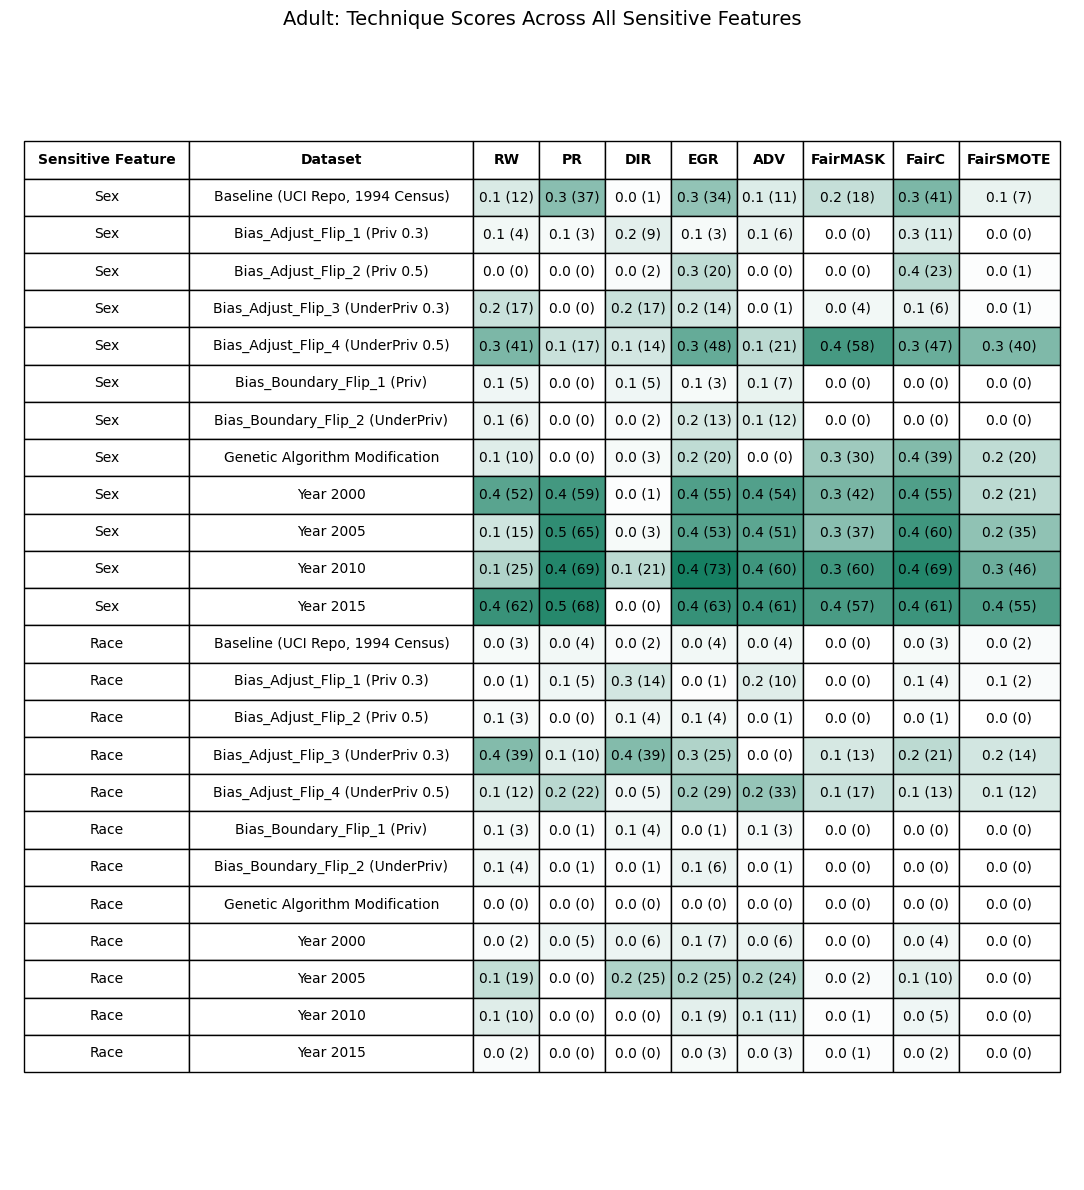

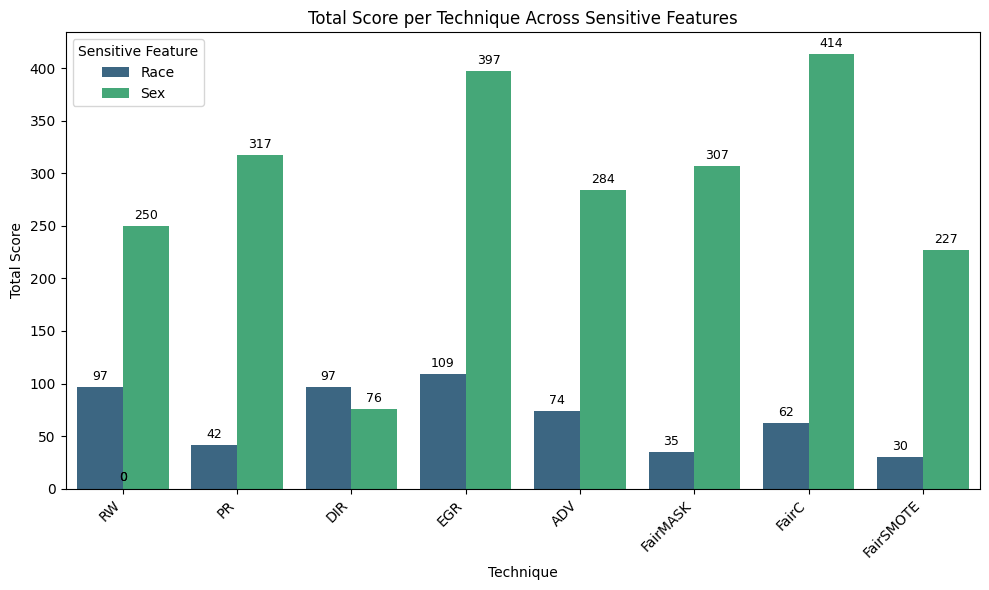

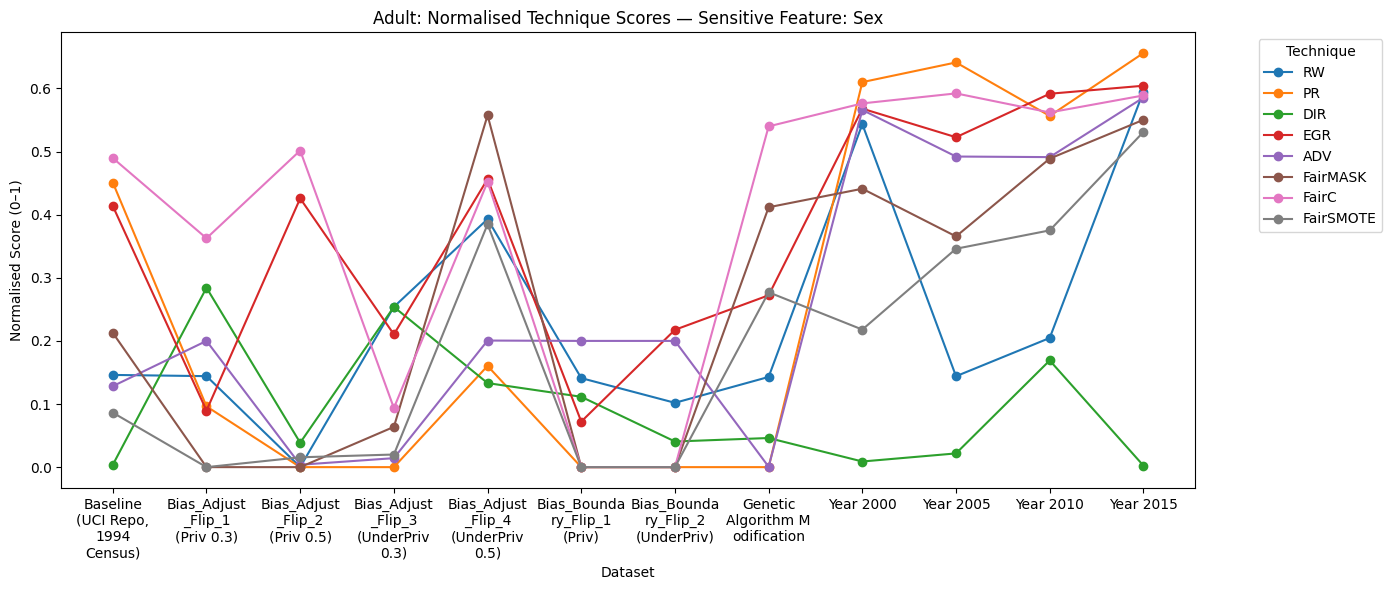

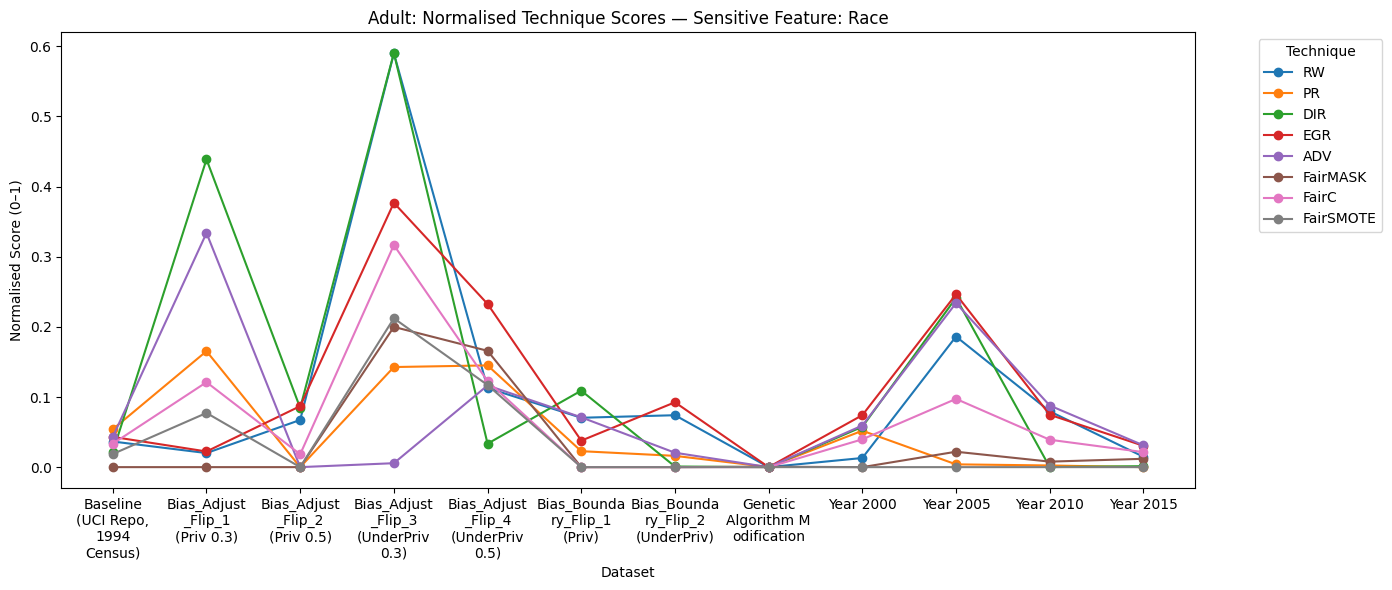

In [24]:
plot_combined_scores("Adult", adult_delta_df, technique_order)

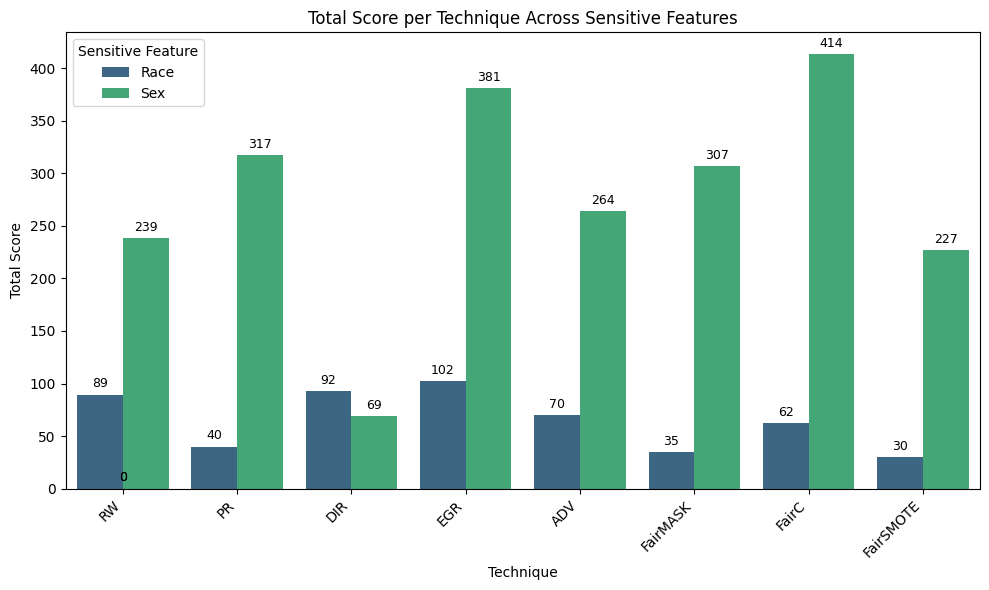

In [25]:
# Calculate cumulative scores per technique excluding versions which did not use all techniques
# Define versions to exclude
versions_to_exclude = [
    "Bias_Boundary_Flip_1 (Priv)",
    "Bias_Boundary_Flip_2 (UnderPriv)"
    ]

adult_total = plot_filtered_scores(adult_delta_df, versions_to_exclude, technique_order)

In [26]:
adult_total

Sensitive Feature  Technique       Score
0               Race        ADV   69.895108
1               Race        DIR   92.420114
2               Race        EGR  102.243004
3               Race      FairC   62.029983
4               Race   FairMASK   35.125591
5               Race  FairSMOTE   30.330501
6               Race         PR   39.954285
7               Race         RW   89.466433
8                Sex        ADV  264.374648
9                Sex        DIR   69.227100
10               Sex        EGR  381.465246
11               Sex      FairC  413.565731
12               Sex   FairMASK  306.719195
13               Sex  FairSMOTE  226.767159
14               Sex         PR  317.323763
15               Sex         RW  238.601698

# German

In [27]:
# Step 1: Load the first 2 rows (the headers)
df_headers = pd.read_csv('/content/drive/MyDrive/UCL_MSc_AI/UCLFinalProj/FinalProj_Main/Results/ResultsCompilation_German.csv', nrows=2, header=None)

# Step 2: Concatenate the two rows column-wise to create a new header
new_header = df_headers.iloc[0].astype(str) + " " + df_headers.iloc[1].astype(str)

# Step 3: Load the rest of the data, skipping the first two rows and applying the new header
german_df = pd.read_csv('/content/drive/MyDrive/UCL_MSc_AI/UCLFinalProj/FinalProj_Main/Results/ResultsCompilation_German.csv', skiprows=2, header=None)
german_df.columns = new_header

# Drop the 'nan' from the column headers
german_df.columns = german_df.columns.str.replace('nan ', '', regex=False)

In [28]:
german_delta_df = compute_deltas(german_df, metrics)
plot_individual_deltas(german_delta_df, technique_order, metrics)
plot_combined_scores("German", german_delta_df, technique_order)

Output hidden; open in https://colab.research.google.com to view.

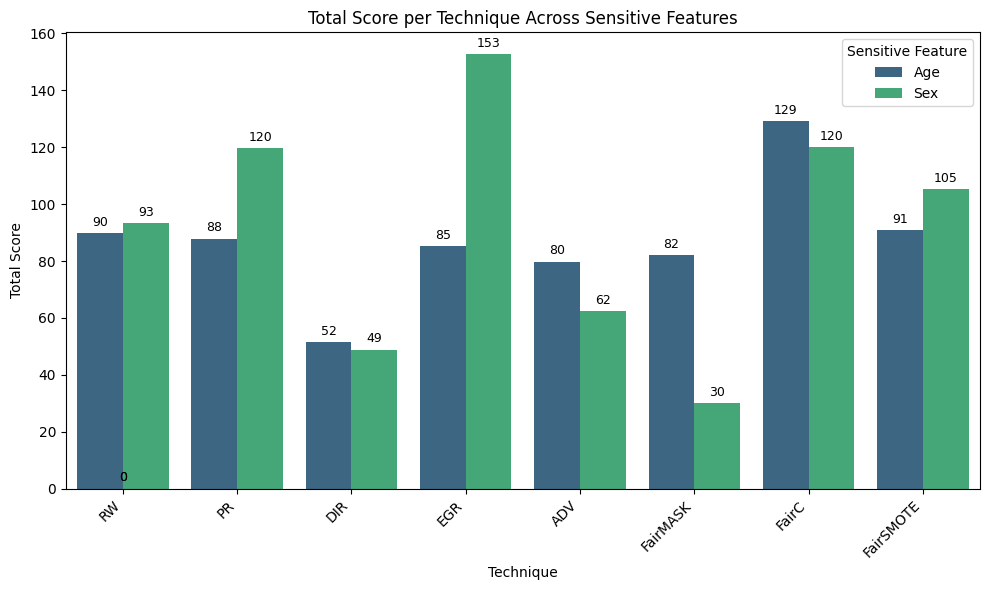

In [29]:
# Calculate cumulative scores per technique excluding versions which did not use all techniques
# Define versions to exclude
versions_to_exclude = [
    "Bias_Boundary_Flip_1 (Priv)",
    "Bias_Boundary_Flip_2 (UnderPriv)",
    "Genetic Algorithm Modification"
    ]

german_total = plot_filtered_scores(german_delta_df, versions_to_exclude, technique_order)

# Student

In [30]:
# Step 1: Load the first 2 rows (the headers)
df_headers = pd.read_csv('/content/drive/MyDrive/UCL_MSc_AI/UCLFinalProj/FinalProj_Main/Results/ResultsCompilation_Student.csv', nrows=2, header=None)

# Step 2: Concatenate the two rows column-wise to create a new header
new_header = df_headers.iloc[0].astype(str) + " " + df_headers.iloc[1].astype(str)

# Step 3: Load the rest of the data, skipping the first two rows and applying the new header
student_df = pd.read_csv('/content/drive/MyDrive/UCL_MSc_AI/UCLFinalProj/FinalProj_Main/Results/ResultsCompilation_Student.csv', skiprows=2, header=None)
student_df.columns = new_header

# Drop the 'nan' from the column headers
student_df.columns = student_df.columns.str.replace('nan ', '', regex=False)

In [31]:
student_delta_df = compute_deltas(student_df, metrics)
plot_individual_deltas(student_delta_df, technique_order, metrics)
plot_combined_scores("Student", student_delta_df, technique_order)

Output hidden; open in https://colab.research.google.com to view.

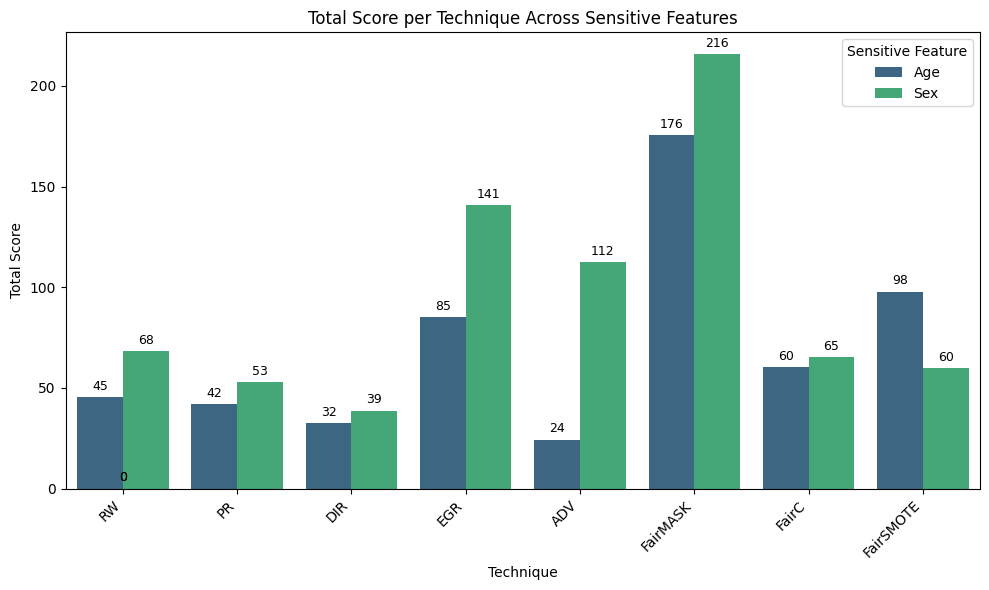

In [32]:
# Calculate cumulative scores per technique excluding versions which did not use all techniques
# Define versions to exclude
versions_to_exclude = [
    "Bias_Boundary_Flip_1 (Priv)",
    "Bias_Boundary_Flip_2 (UnderPriv)"
    ]

student_total = plot_filtered_scores(student_delta_df, versions_to_exclude, technique_order)

#Summary of 3 domains

In [33]:
# Add a column to identify the dataset
adult_total["Dataset"] = "Adult"
german_total["Dataset"] = "German"
student_total["Dataset"] = "Student"

# Combine all tables
combined_df = pd.concat([adult_total, german_total, student_total], ignore_index=True)

# Pivot the table: rows = Dataset + Sensitive Feature, columns = Technique, values = Score
combined_pivot = combined_df.pivot_table(
    index=["Dataset", "Sensitive Feature"],
    columns="Technique",
    values="Score"
)

# Reset index so Dataset and Sensitive Feature are columns
combined_pivot = combined_pivot.reset_index()

# Reorder techniques if needed
technique_order = ["RW", "PR", "DIR", "EGR", "ADV", "FairMASK", "FairC", "FairSMOTE"]
combined_pivot = combined_pivot[['Dataset', 'Sensitive Feature'] + [t for t in technique_order if t in combined_pivot.columns]]

# Compute totals for numeric columns only
totals = combined_pivot.drop(columns=["Dataset", "Sensitive Feature"]).sum(numeric_only=True)

# Create a DataFrame row for the totals
total_row = pd.DataFrame(
    [["Total", "All"] + totals.tolist()],
    columns=combined_pivot.columns
)

# Append to pivot table
combined_pivot_with_total = pd.concat([combined_pivot, total_row], ignore_index=True)

# Display the combined table
combined_pivot_with_total

Technique  Dataset Sensitive Feature          RW          PR         DIR  \
0            Adult              Race   89.466433   39.954285   92.420114   
1            Adult               Sex  238.601698  317.323763   69.227100   
2           German               Age   89.921953   87.914868   51.517426   
3           German               Sex   93.234308  119.729183   48.867861   
4          Student               Age   45.498696   42.138920   32.498728   
5          Student               Sex   68.338257   52.727225   38.773520   
6            Total               All  625.061345  659.788243  333.304749   

Technique         EGR         ADV    FairMASK       FairC   FairSMOTE  
0          102.243004   69.895108   35.125591   62.029983   30.330501  
1          381.465246  264.374648  306.719195  413.565731  226.767159  
2           85.209204   79.820628   82.183630  129.262290   90.843892  
3          152.757152   62.494120   29.971081  119.969607  105.294509  
4           85.015163   24.346107  175.520851   60.337579   97.842399  
5          140.772208  112.374289  215.808789   65.366578   59.659528  
6          947.461976  613.304900  845.329137  850.531768  610.737989

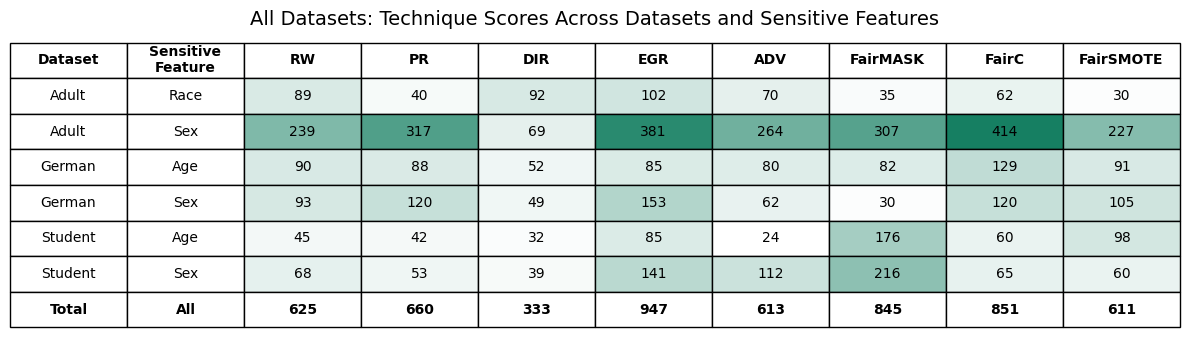

In [37]:
plot_combined_results_table(combined_pivot_with_total, technique_order, name="All Datasets")

# Adult Multi Feature - Datasets Modified for Sex

In [ ]:
# Define metrics for all domains
performance_metrics = ["Acc"]
fairness_metrics = ["DI", "SPD", "EOPD", "EOD", "AOD"]
metrics = performance_metrics + fairness_metrics

In [ ]:
# Step 1: Load the first 2 rows (the headers)
df_headers = pd.read_csv('/content/drive/MyDrive/UCL_MSc_AI/UCLFinalProj/FinalProj_Main/Results/ResultsComp_Multi_AdultSex.csv', nrows=2, header=None)

# Step 2: Concatenate the two rows column-wise to create a new header
new_header = df_headers.iloc[0].astype(str) + " " + df_headers.iloc[1].astype(str)

# Step 3: Load the rest of the data, skipping the first two rows and applying the new header
adult_multi_df = pd.read_csv('/content/drive/MyDrive/UCL_MSc_AI/UCLFinalProj/FinalProj_Main/Results/ResultsComp_Multi_AdultSex.csv', skiprows=2, header=None)
adult_multi_df.columns = new_header

# Drop the 'nan' from the column headers
adult_multi_df.columns = adult_multi_df.columns.str.replace('nan ', '', regex=False)

In [ ]:
# Define technique order for Student
technique_order = ["M3Fair", "RW1", "RW2", "FairC"]

adult_multi_delta_df = compute_deltas(adult_multi_df, metrics)
plot_individual_deltas(adult_multi_delta_df, technique_order, metrics)
plot_combined_scores("Adult_Sex", adult_multi_delta_df, technique_order)

Output hidden; open in https://colab.research.google.com to view.

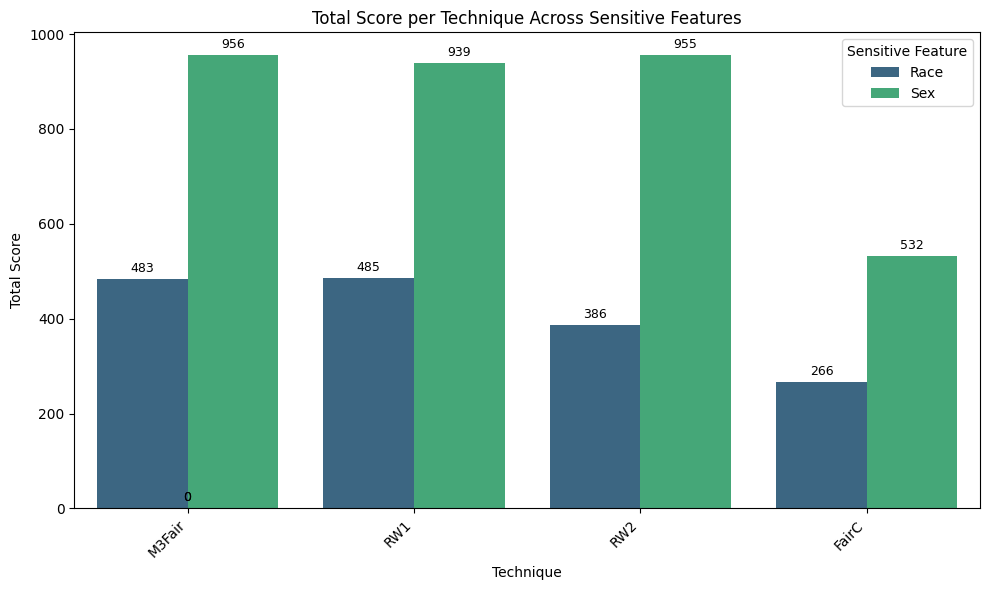

In [ ]:
versions_to_exclude = [
    "Bias_Boundary_Flip_1 (Priv)",
    "Bias_Boundary_Flip_2 (UnderPriv)"
    ]

adult_multi_total_sex = plot_filtered_scores(adult_multi_delta_df, versions_to_exclude, technique_order)

# Adult Multi-Feature - Datasets Modified for Race

In [ ]:
# Step 1: Load the first 2 rows (the headers)
df_headers = pd.read_csv('/content/drive/MyDrive/UCL_MSc_AI/UCLFinalProj/FinalProj_Main/Results/ResultsComp_Multi_AdultRace.csv', nrows=2, header=None)

# Step 2: Concatenate the two rows column-wise to create a new header
new_header = df_headers.iloc[0].astype(str) + " " + df_headers.iloc[1].astype(str)

# Step 3: Load the rest of the data, skipping the first two rows and applying the new header
adultrace_multi_df = pd.read_csv('/content/drive/MyDrive/UCL_MSc_AI/UCLFinalProj/FinalProj_Main/Results/ResultsComp_Multi_AdultRace.csv', skiprows=2, header=None)
adultrace_multi_df.columns = new_header

# Drop the 'nan' from the column headers
adultrace_multi_df.columns = adultrace_multi_df.columns.str.replace('nan ', '', regex=False)

In [ ]:
# Define technique order for Student
technique_order = ["M3Fair", "RW1", "RW2", "FairC"]

adultrace_multi_delta_df = compute_deltas(adultrace_multi_df, metrics)
plot_individual_deltas(adultrace_multi_delta_df, technique_order, metrics)
plot_combined_scores("Adult", adultrace_multi_delta_df, technique_order)

Output hidden; open in https://colab.research.google.com to view.

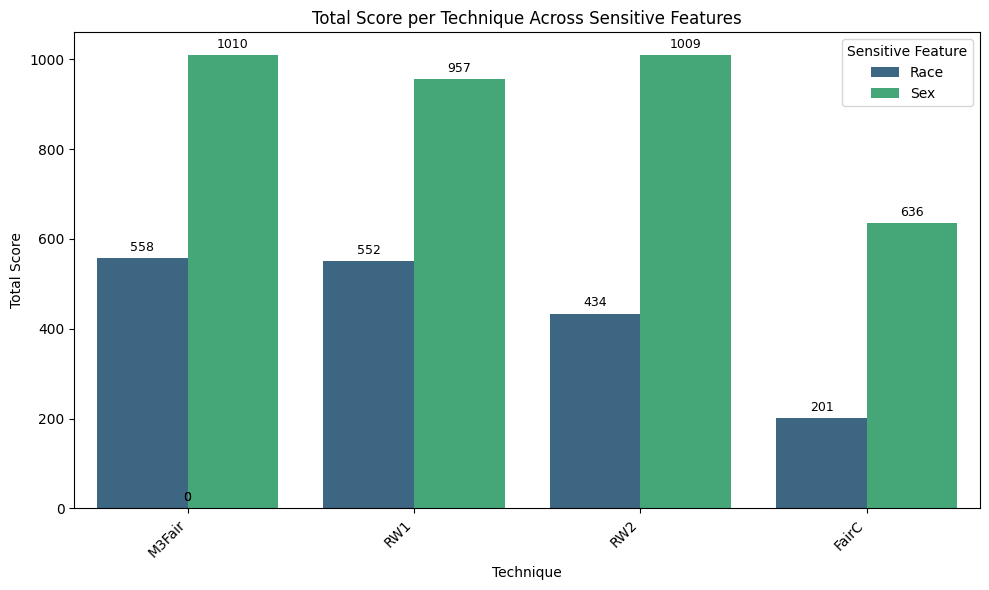

In [ ]:
versions_to_exclude = [
    "Bias_Boundary_Flip_1 (Priv)",
    "Bias_Boundary_Flip_2 (UnderPriv)"
    ]

adult_multi_total_race = plot_filtered_scores(adultrace_multi_delta_df, versions_to_exclude, technique_order)

# German Multi-Feature - Datasets Modified for Sex

In [ ]:
# Step 1: Load the first 2 rows (the headers)
df_headers = pd.read_csv('/content/drive/MyDrive/UCL_MSc_AI/UCLFinalProj/FinalProj_Main/Results/ResultsComp_Multi_GermanSex.csv', nrows=2, header=None)

# Step 2: Concatenate the two rows column-wise to create a new header
new_header = df_headers.iloc[0].astype(str) + " " + df_headers.iloc[1].astype(str)

# Step 3: Load the rest of the data, skipping the first two rows and applying the new header
german_multi_df = pd.read_csv('/content/drive/MyDrive/UCL_MSc_AI/UCLFinalProj/FinalProj_Main/Results/ResultsComp_Multi_GermanSex.csv', skiprows=2, header=None)
german_multi_df.columns = new_header

# Drop the 'nan' from the column headers
german_multi_df.columns = german_multi_df.columns.str.replace('nan ', '', regex=False)

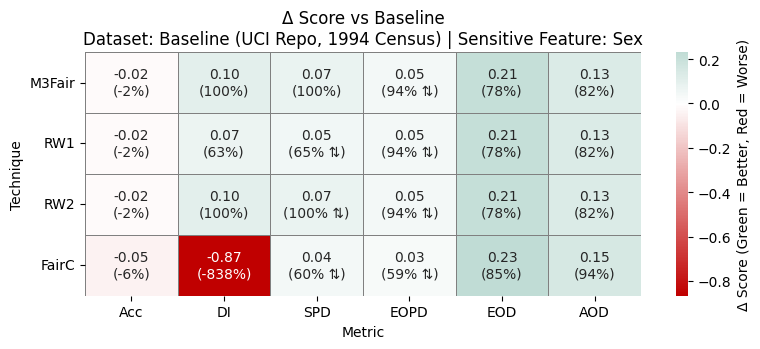

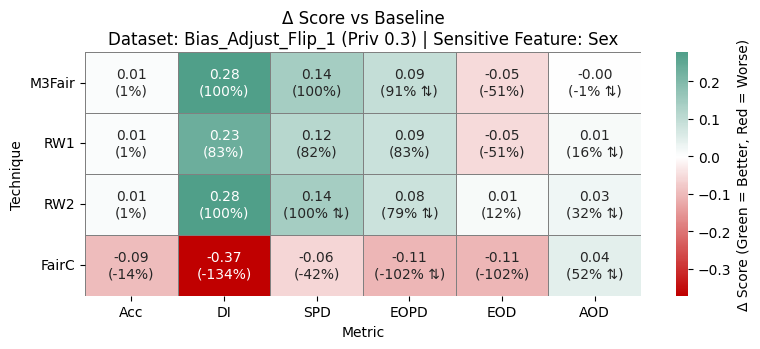

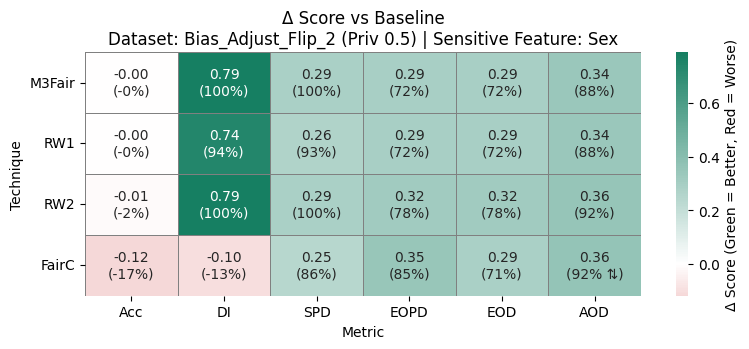

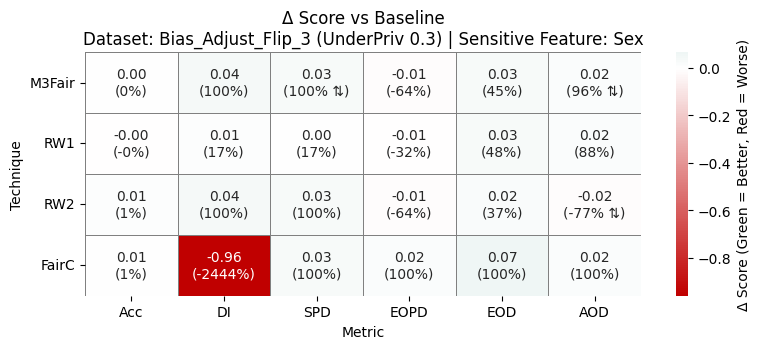

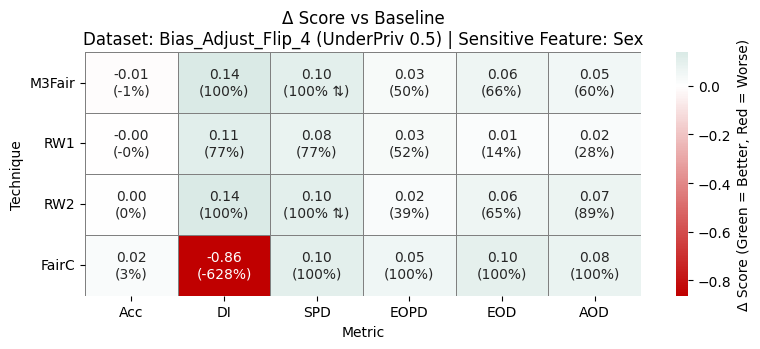

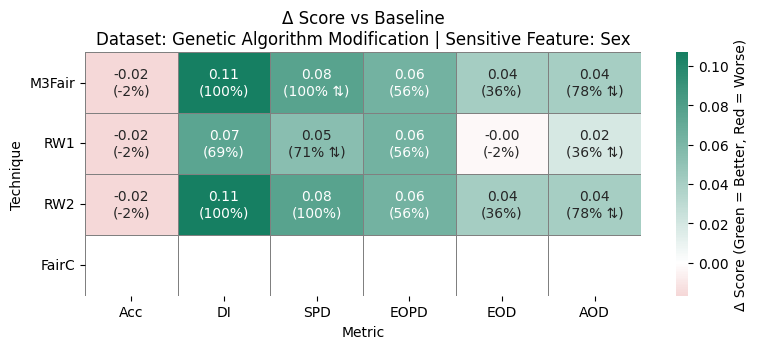

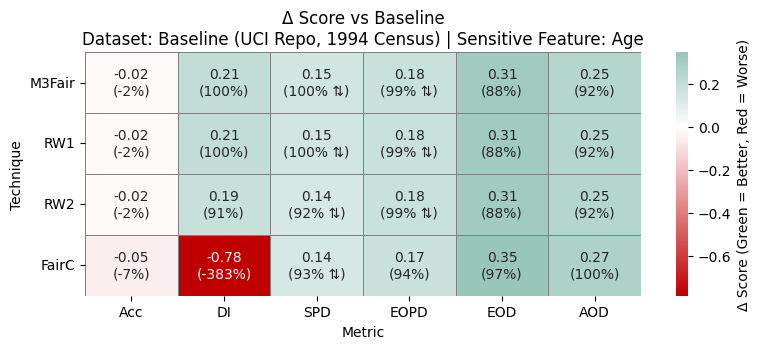

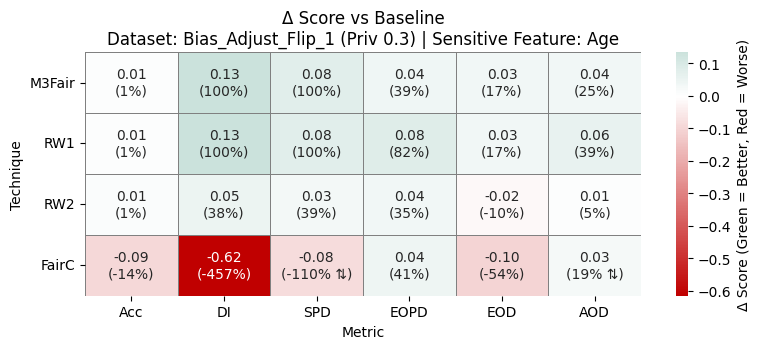

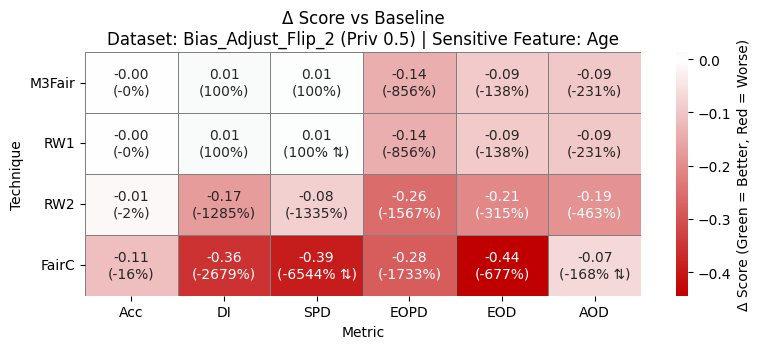

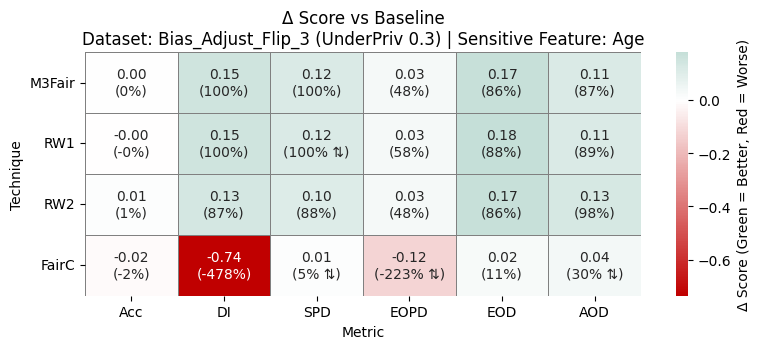

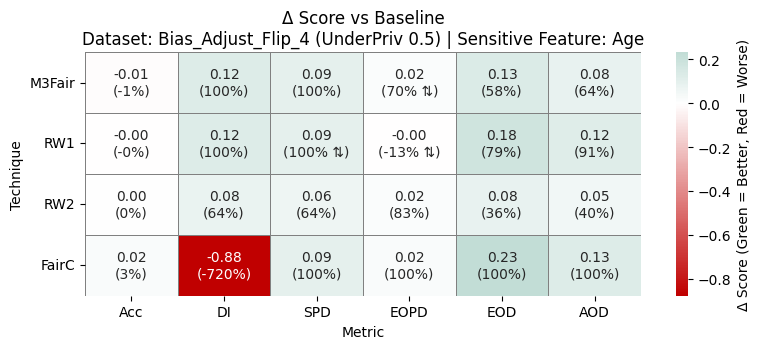

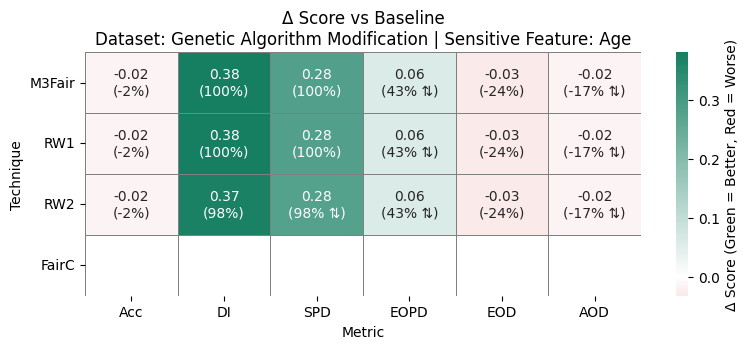

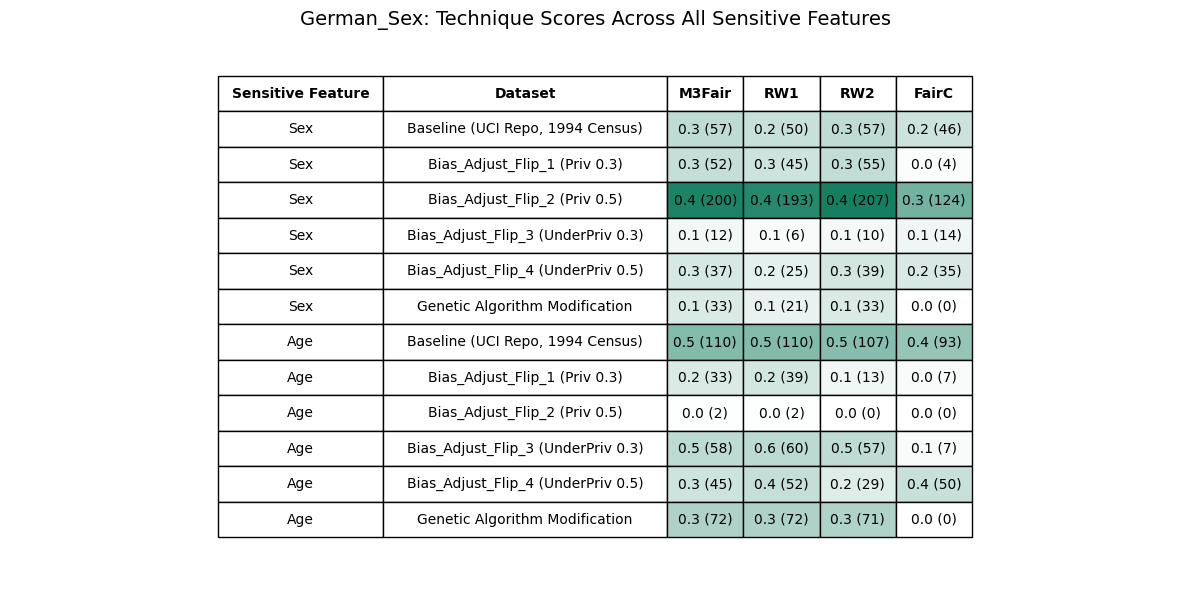

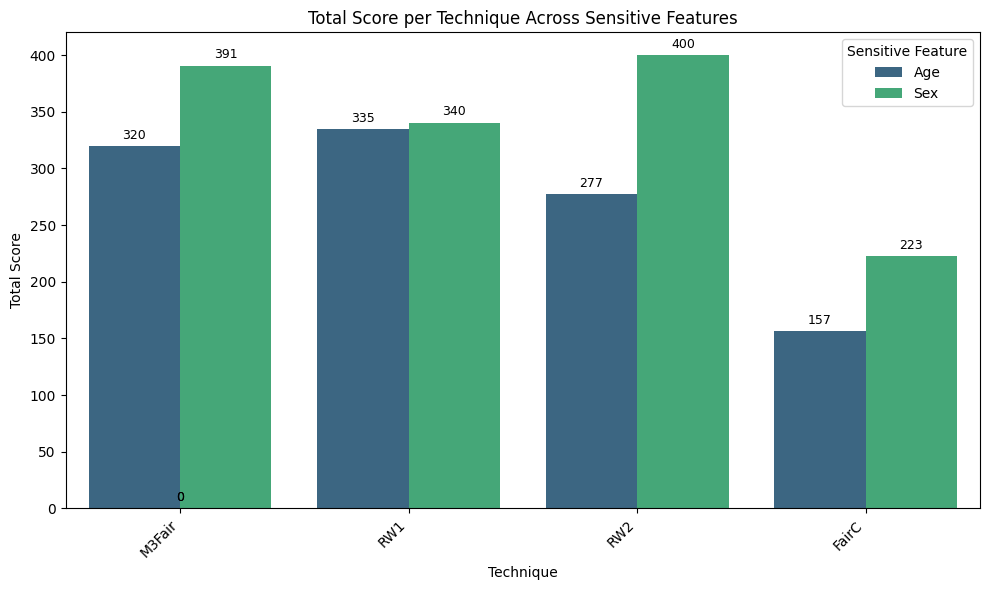

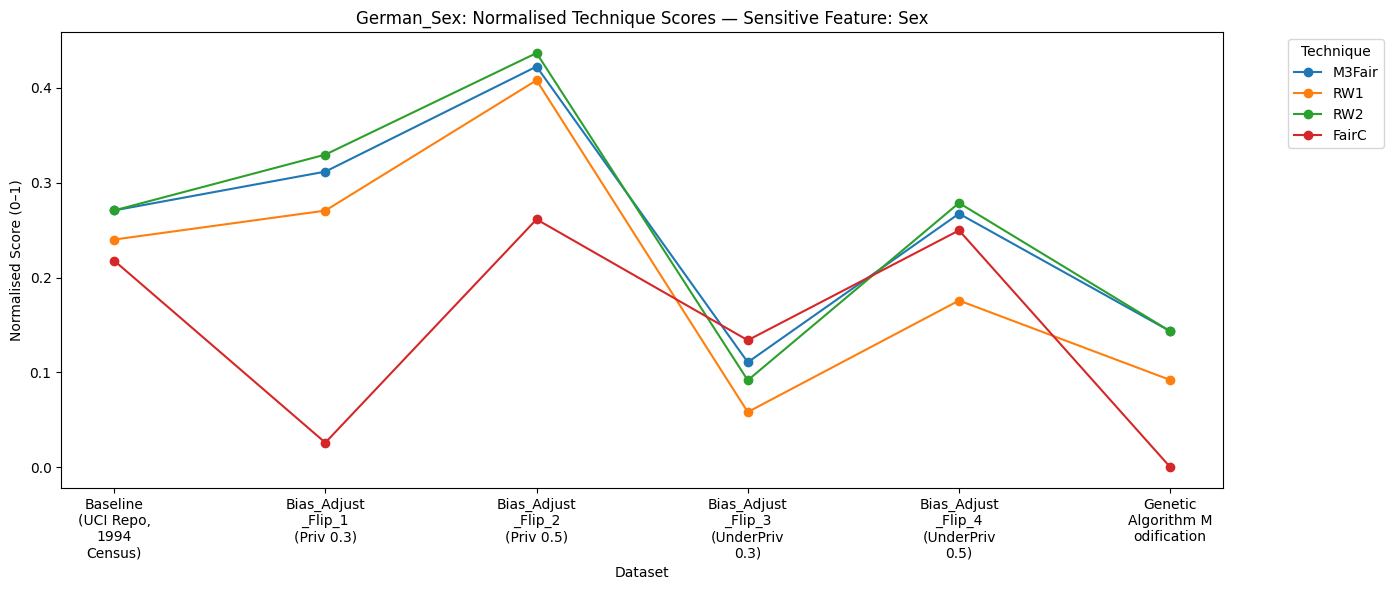

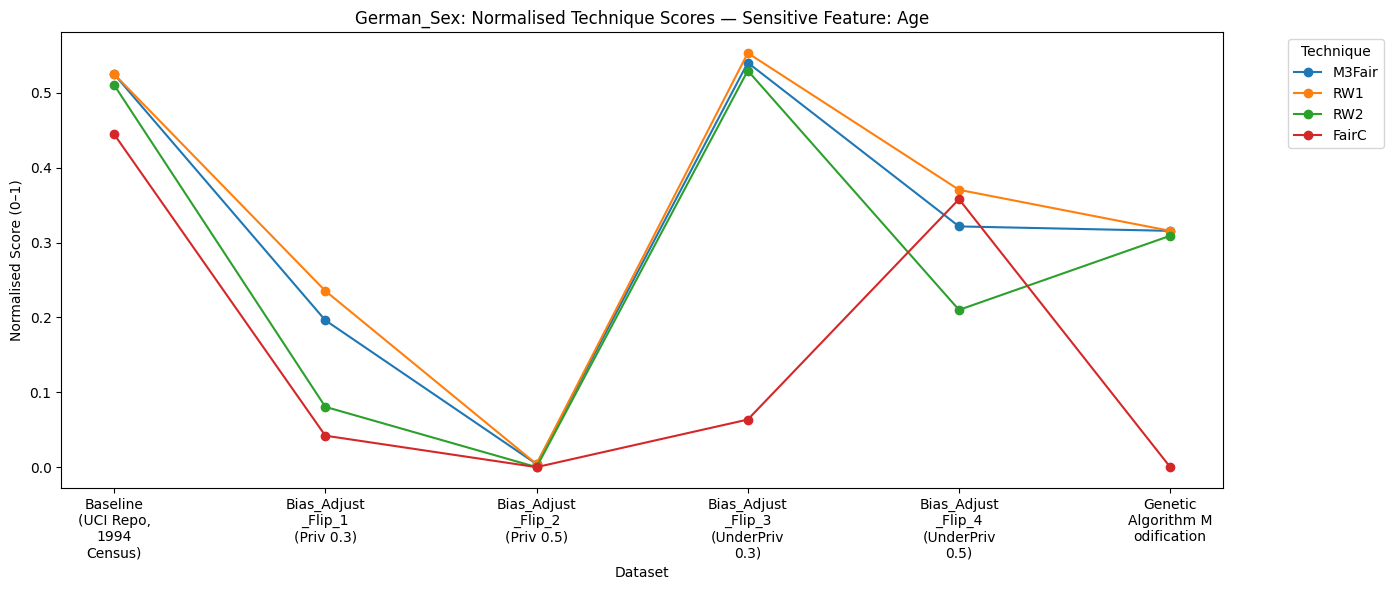

In [ ]:
# Define technique order for Student
technique_order = ["M3Fair", "RW1", "RW2", "FairC"]

german_multi_delta_df = compute_deltas(german_multi_df, metrics)
plot_individual_deltas(german_multi_delta_df, technique_order, metrics)
plot_combined_scores("German_Sex", german_multi_delta_df, technique_order)

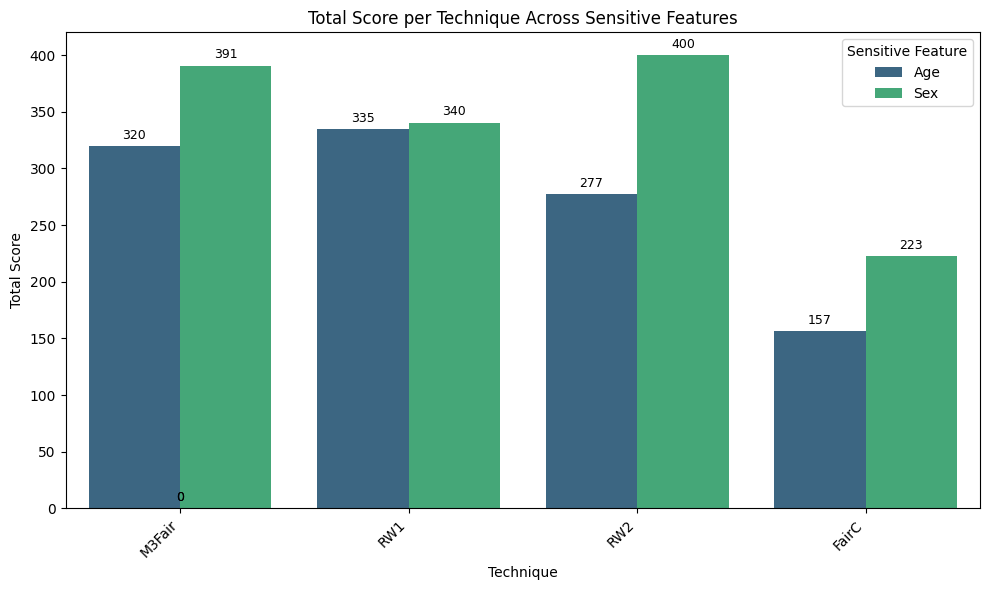

In [ ]:
versions_to_exclude = [
    "Bias_Boundary_Flip_1 (Priv)",
    "Bias_Boundary_Flip_2 (UnderPriv)"
    ]

german_multi_total_sex = plot_filtered_scores(german_multi_delta_df, versions_to_exclude, technique_order)

# German Multi-Feature - Datasets Modified for Age

In [ ]:
# Step 1: Load the first 2 rows (the headers)
df_headers = pd.read_csv('/content/drive/MyDrive/UCL_MSc_AI/UCLFinalProj/FinalProj_Main/Results/ResultsComp_Multi_GermanAge.csv', nrows=2, header=None)

# Step 2: Concatenate the two rows column-wise to create a new header
new_header = df_headers.iloc[0].astype(str) + " " + df_headers.iloc[1].astype(str)

# Step 3: Load the rest of the data, skipping the first two rows and applying the new header
germanage_multi_df = pd.read_csv('/content/drive/MyDrive/UCL_MSc_AI/UCLFinalProj/FinalProj_Main/Results/ResultsComp_Multi_GermanAge.csv', skiprows=2, header=None)
germanage_multi_df.columns = new_header

# Drop the 'nan' from the column headers
germanage_multi_df.columns = germanage_multi_df.columns.str.replace('nan ', '', regex=False)

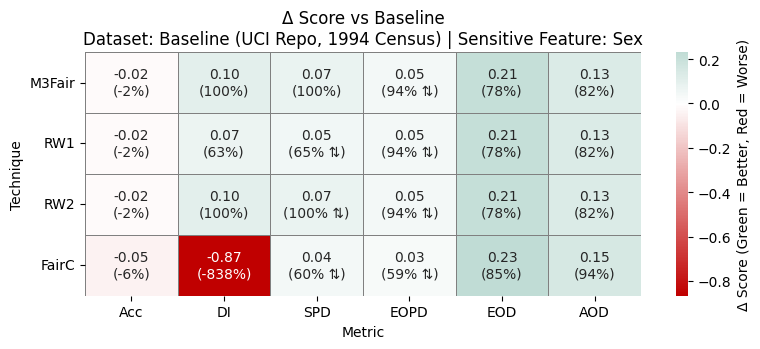

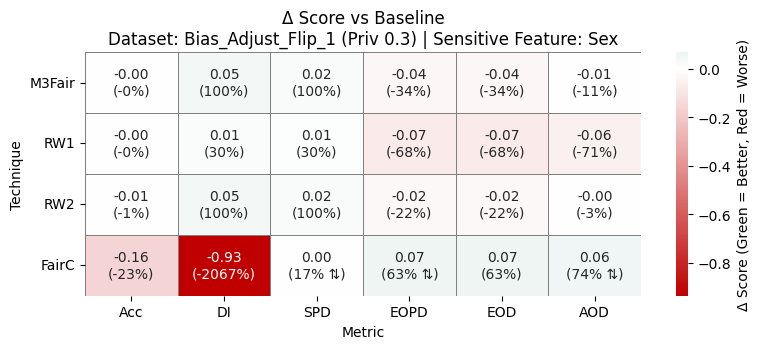

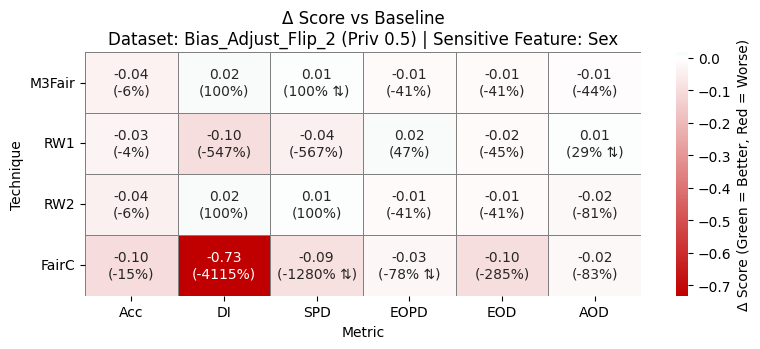

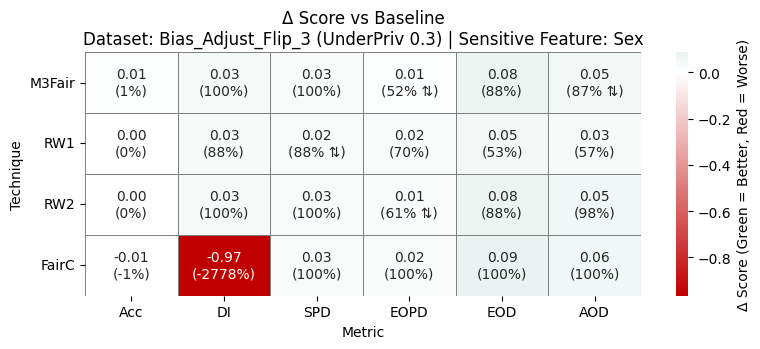

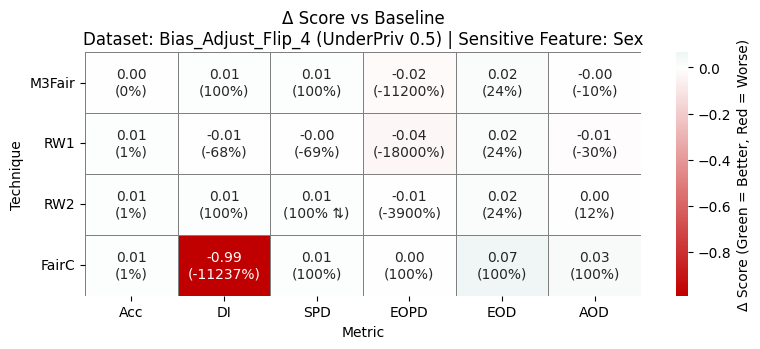

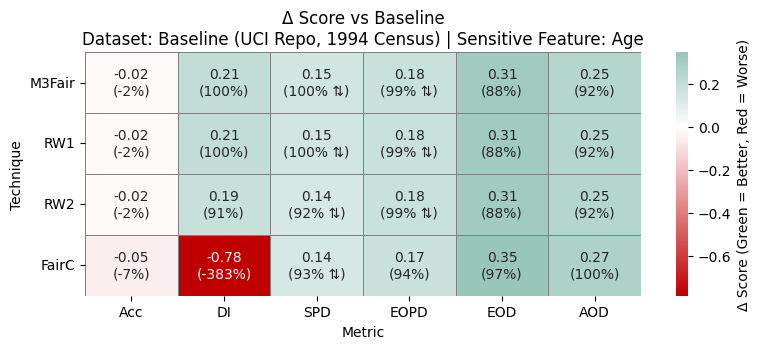

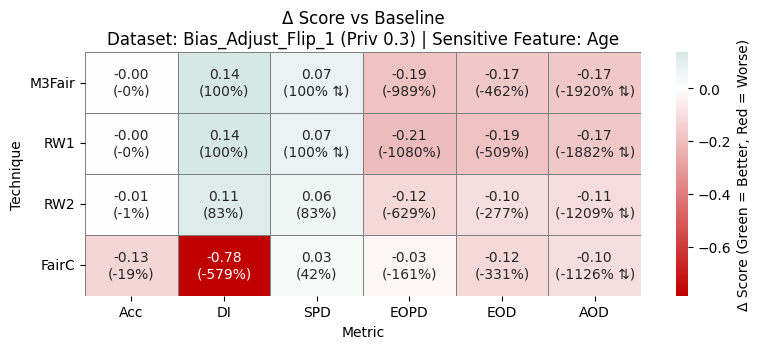

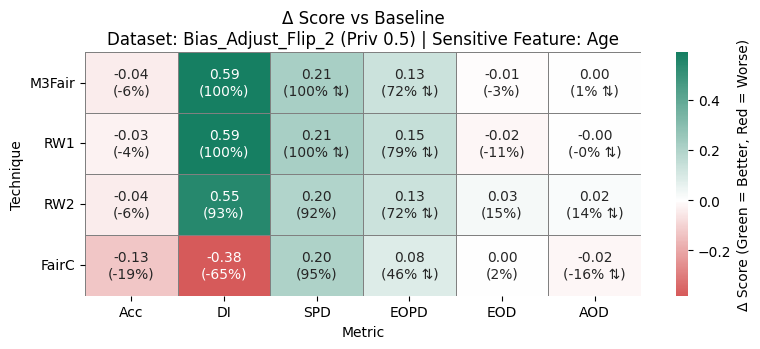

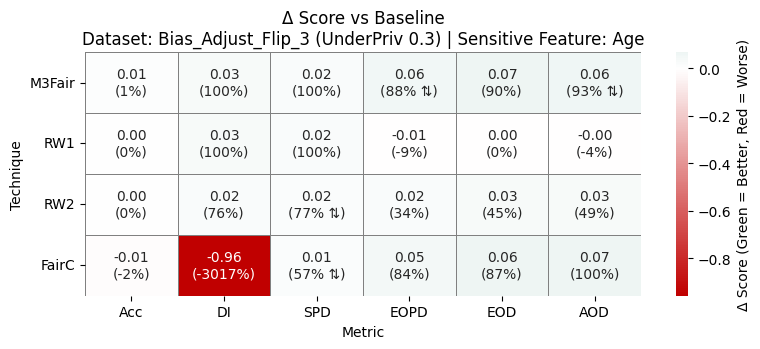

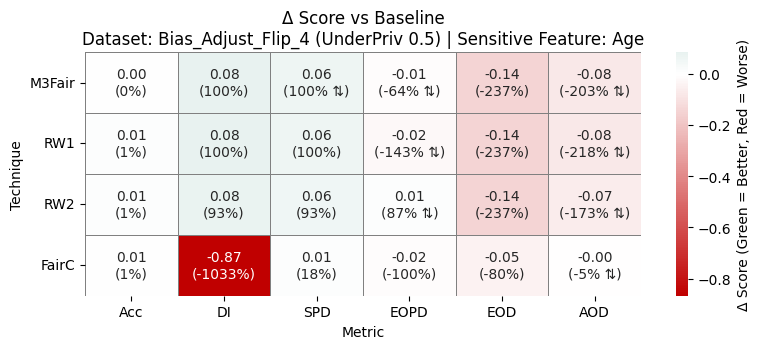

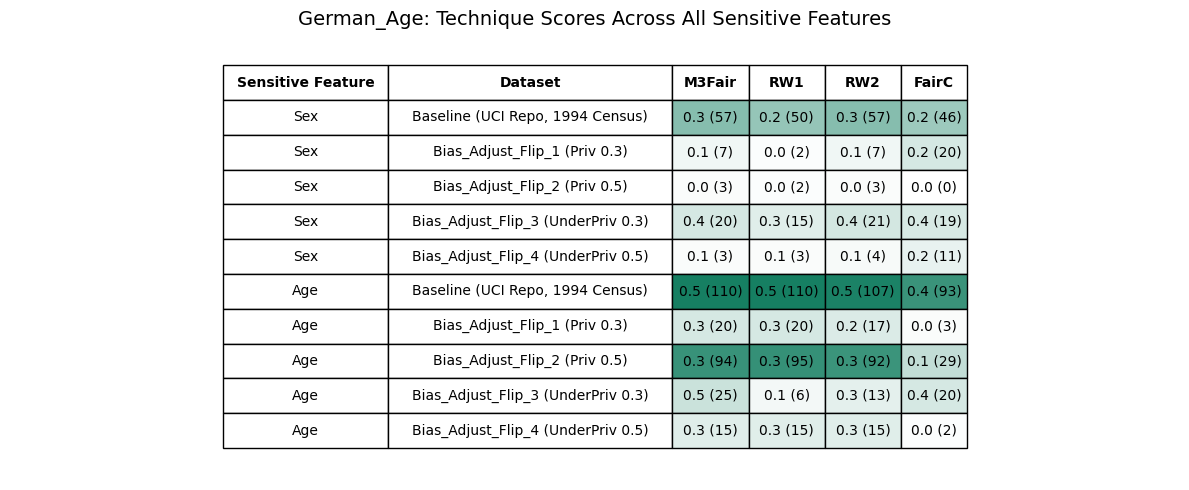

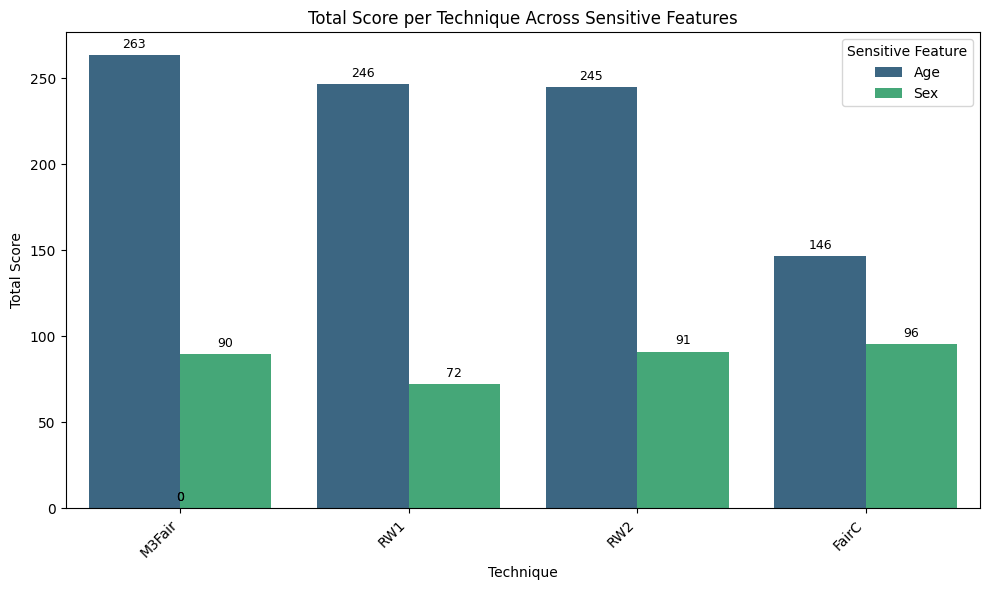

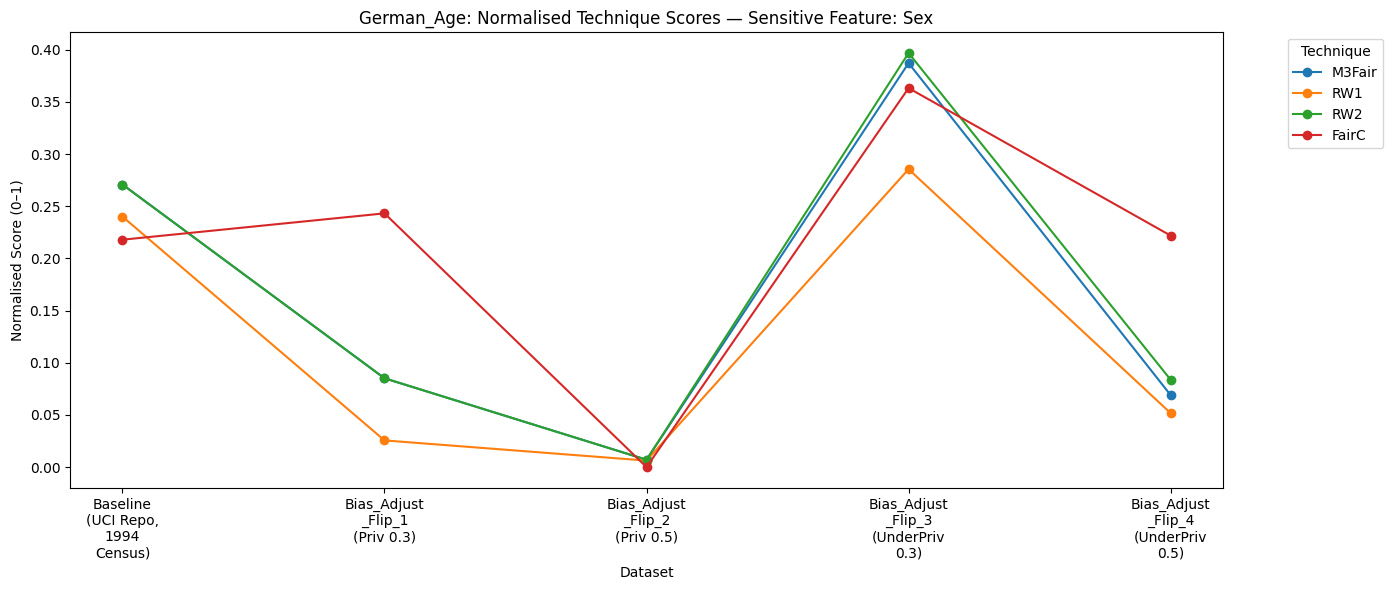

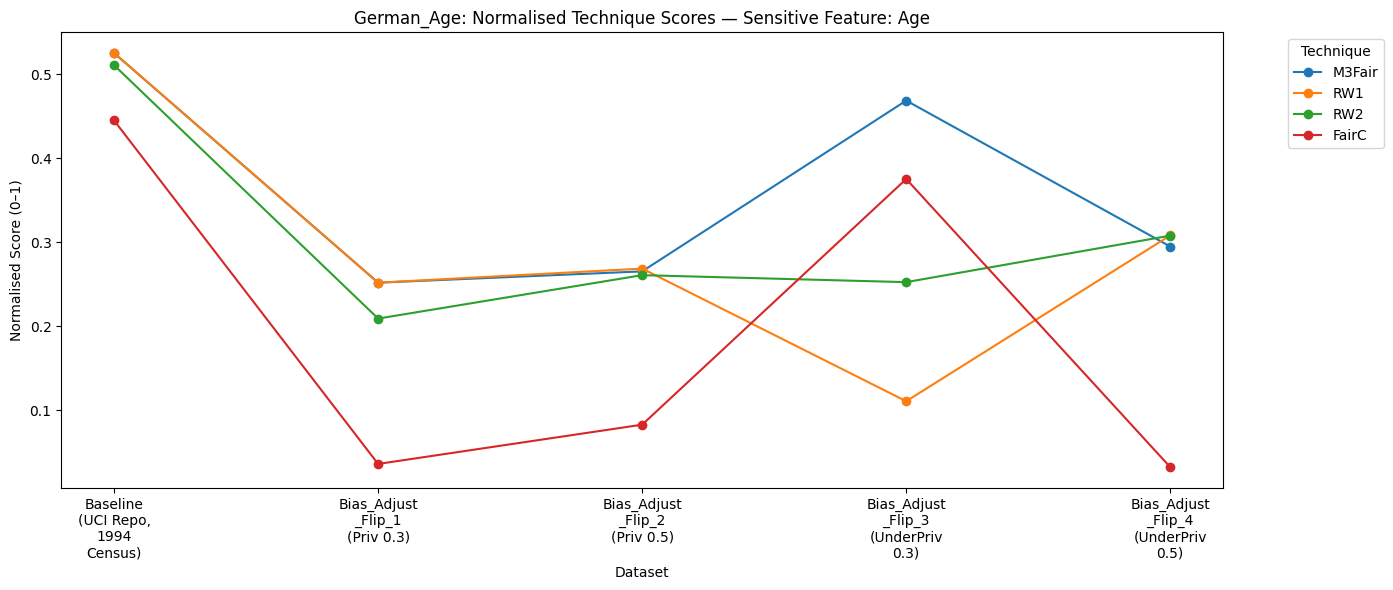

In [ ]:
# Define technique order for Student
technique_order = ["M3Fair", "RW1", "RW2", "FairC"]

germanage_multi_delta_df = compute_deltas(germanage_multi_df, metrics)
plot_individual_deltas(germanage_multi_delta_df, technique_order, metrics)
plot_combined_scores("German_Age", germanage_multi_delta_df, technique_order)

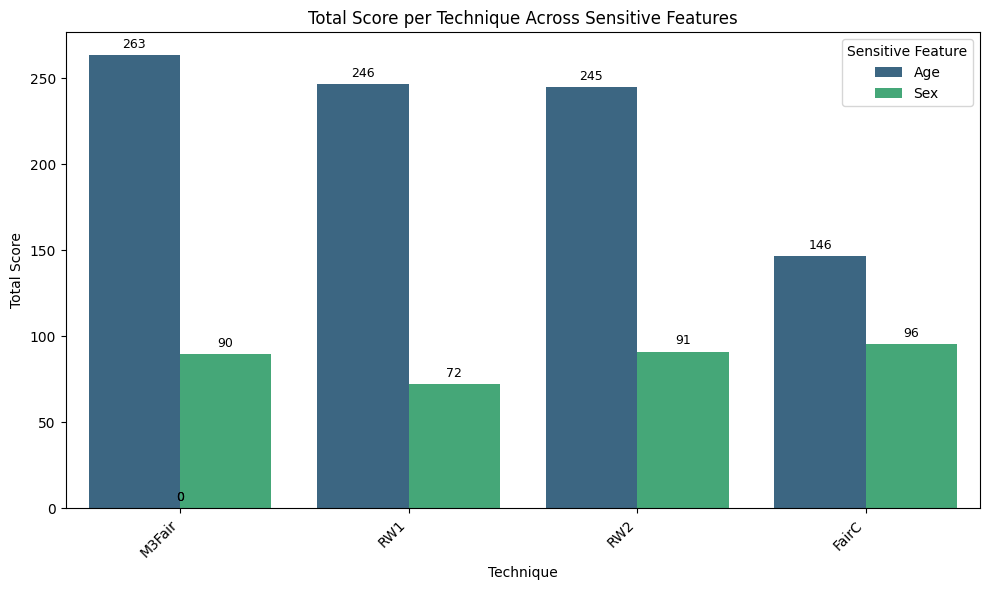

In [ ]:
versions_to_exclude = [
    "Bias_Boundary_Flip_1 (Priv)",
    "Bias_Boundary_Flip_2 (UnderPriv)"
    ]

german_multi_total_age = plot_filtered_scores(germanage_multi_delta_df, versions_to_exclude, technique_order)

# Student Multi-feature - Datasets Modified for Sex


In [ ]:
# Step 1: Load the first 2 rows (the headers)
df_headers = pd.read_csv('/content/drive/MyDrive/UCL_MSc_AI/UCLFinalProj/FinalProj_Main/Results/ResultsComp_Multi_StuSex_1.csv', nrows=2, header=None)

# Step 2: Concatenate the two rows column-wise to create a new header
new_header = df_headers.iloc[0].astype(str) + " " + df_headers.iloc[1].astype(str)

# Step 3: Load the rest of the data, skipping the first two rows and applying the new header
stu_multi_df = pd.read_csv('/content/drive/MyDrive/UCL_MSc_AI/UCLFinalProj/FinalProj_Main/Results/ResultsComp_Multi_StuSex_1.csv', skiprows=2, header=None)
stu_multi_df.columns = new_header

# Drop the 'nan' from the column headers
stu_multi_df.columns = stu_multi_df.columns.str.replace('nan ', '', regex=False)

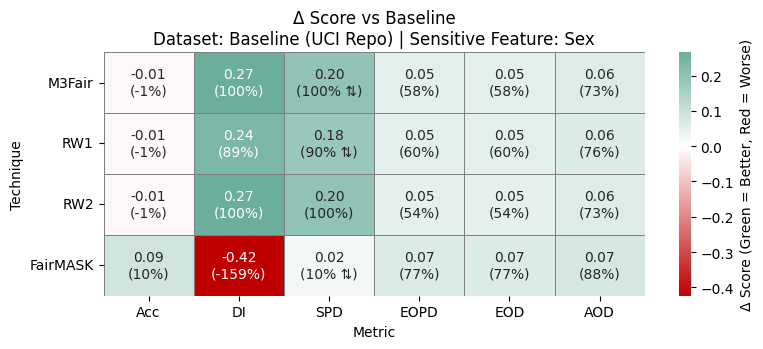

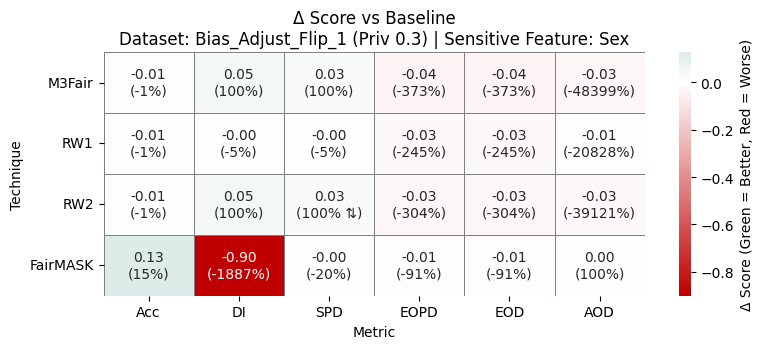

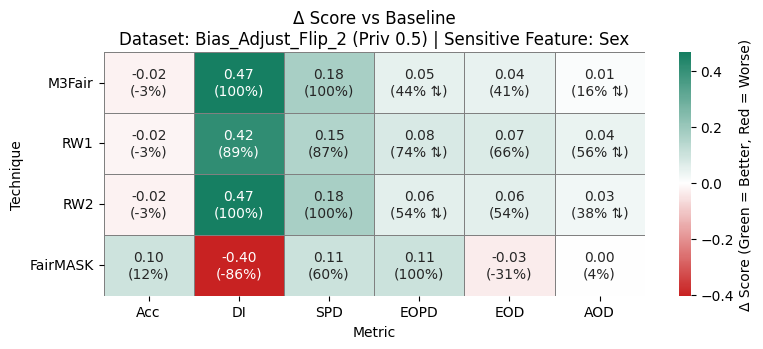

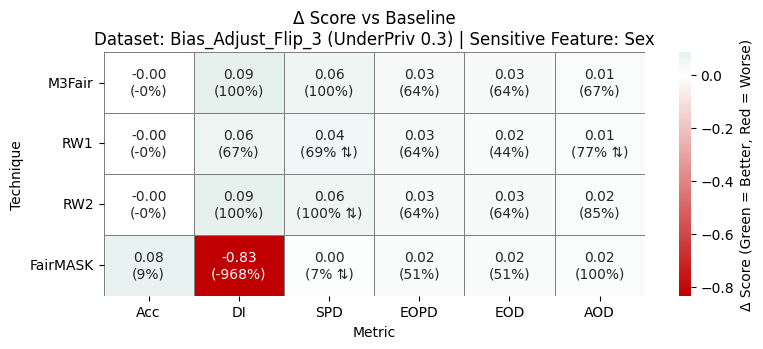

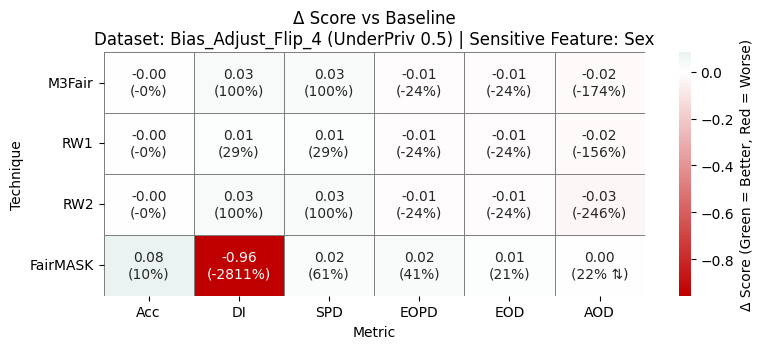

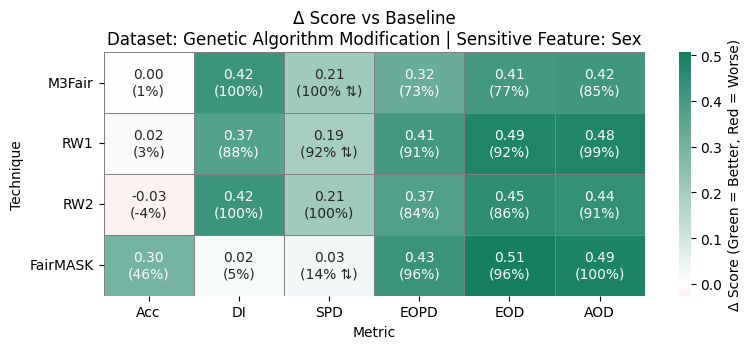

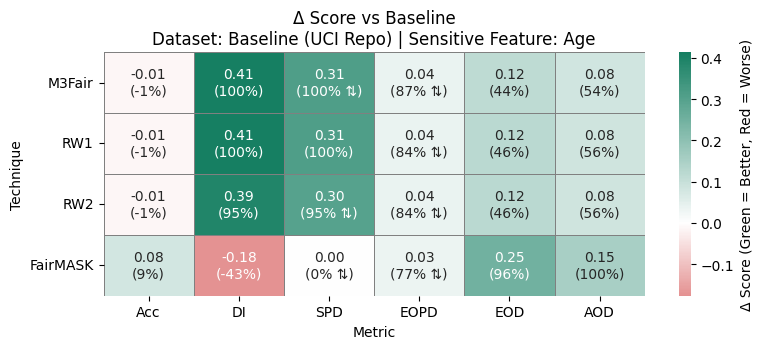

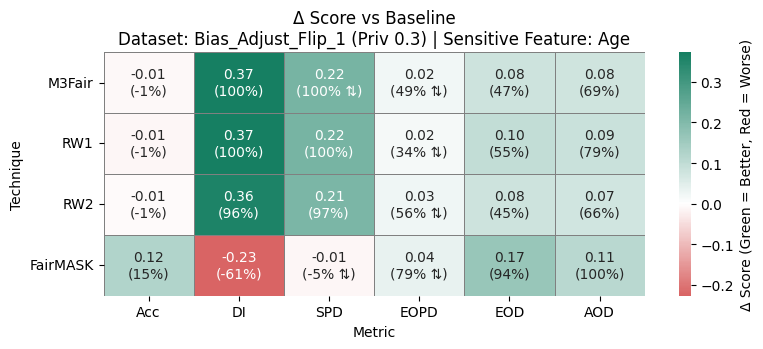

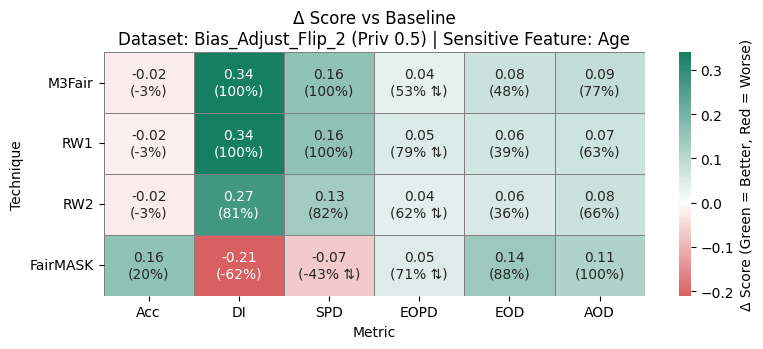

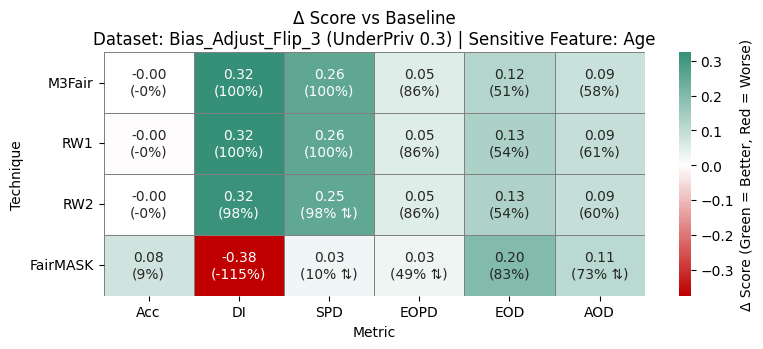

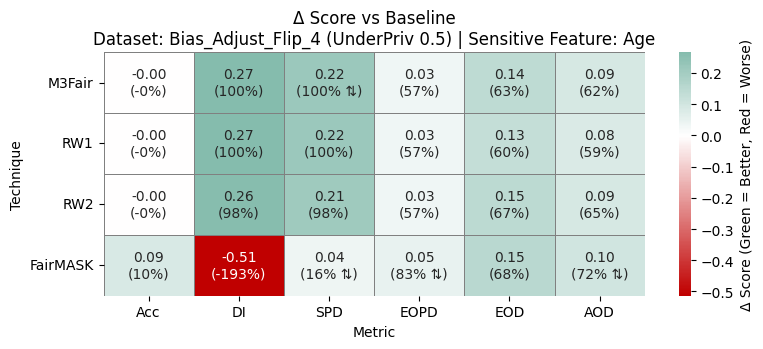

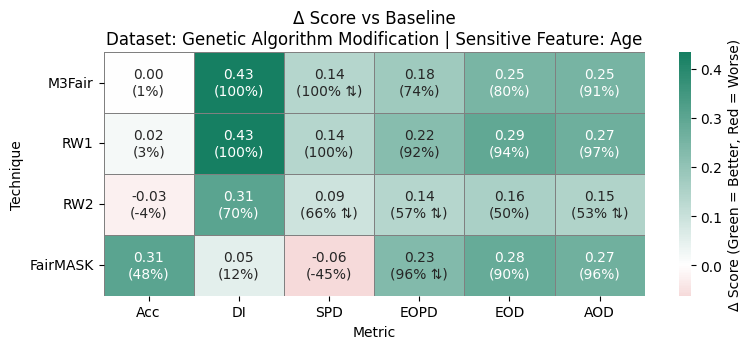

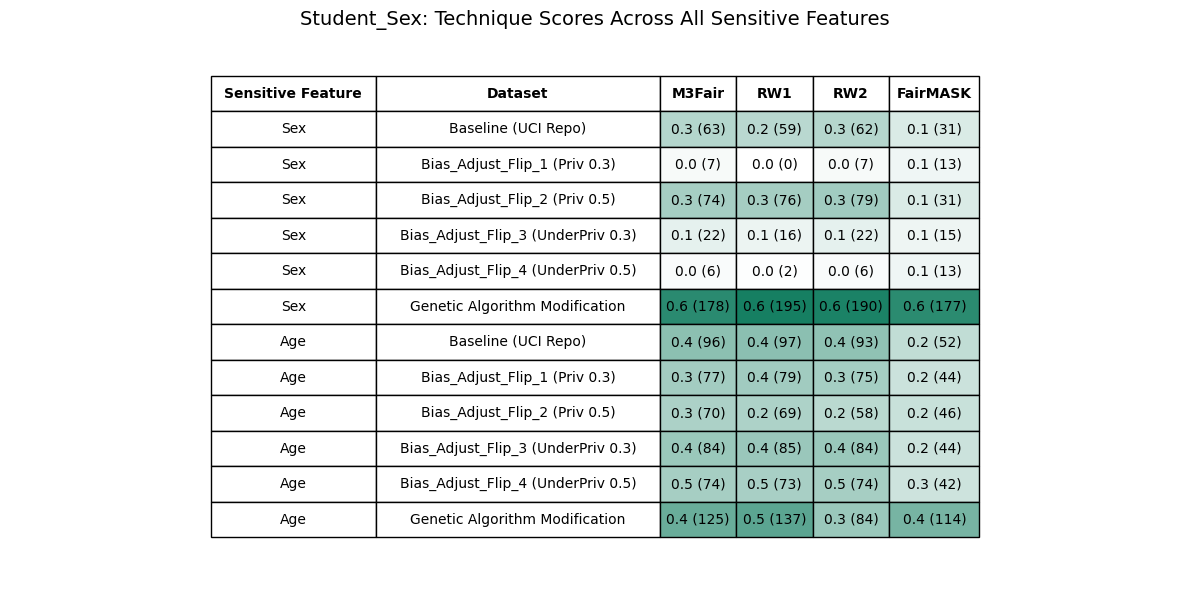

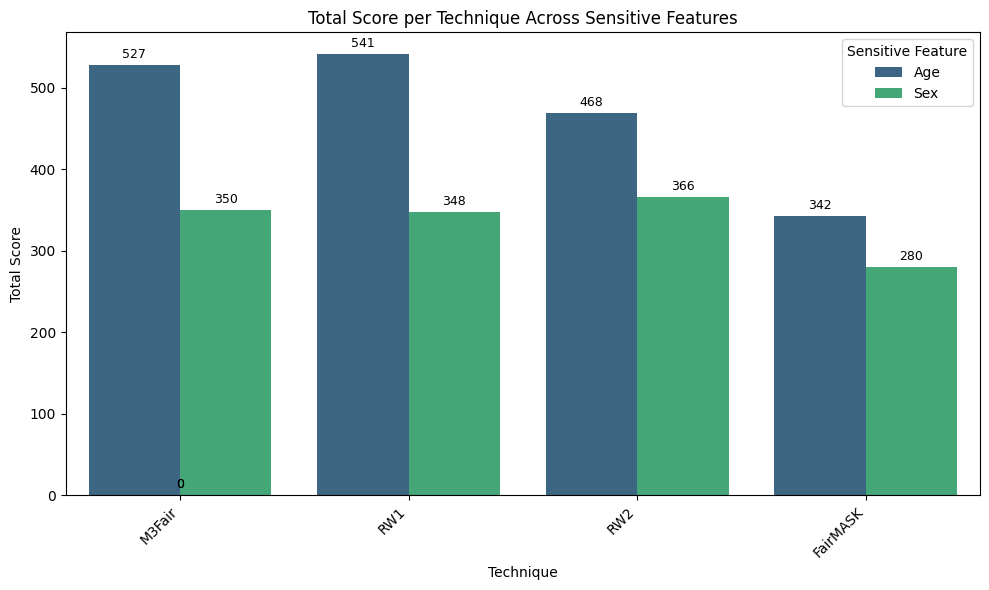

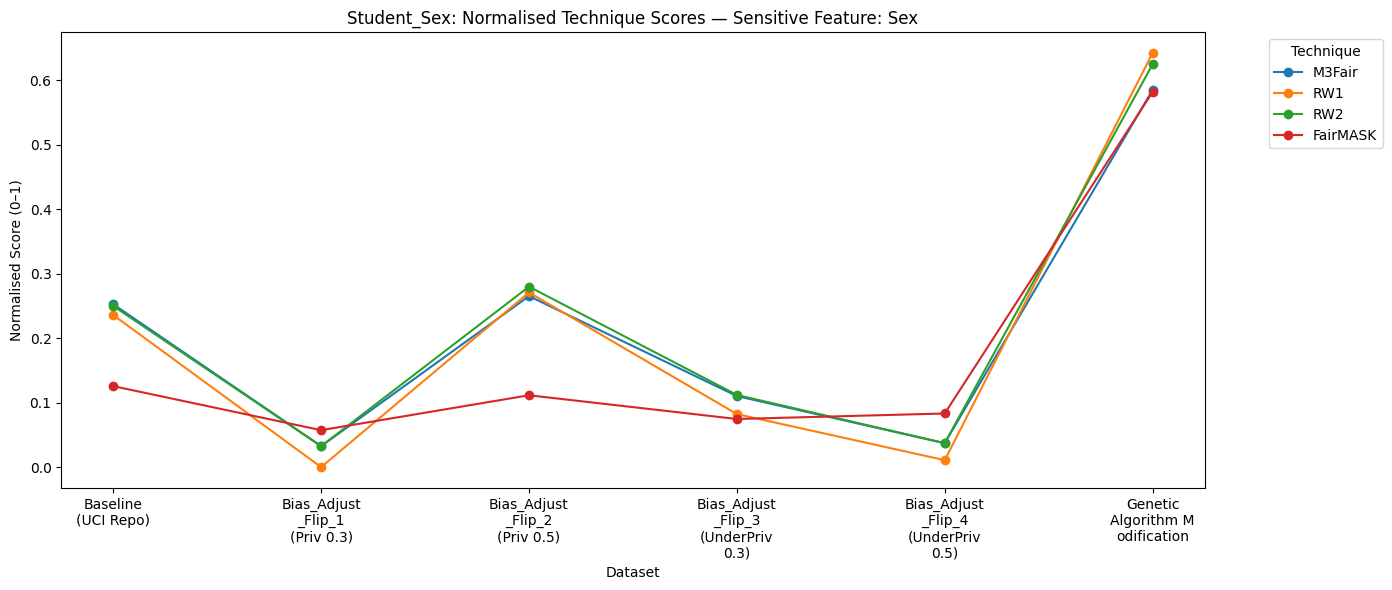

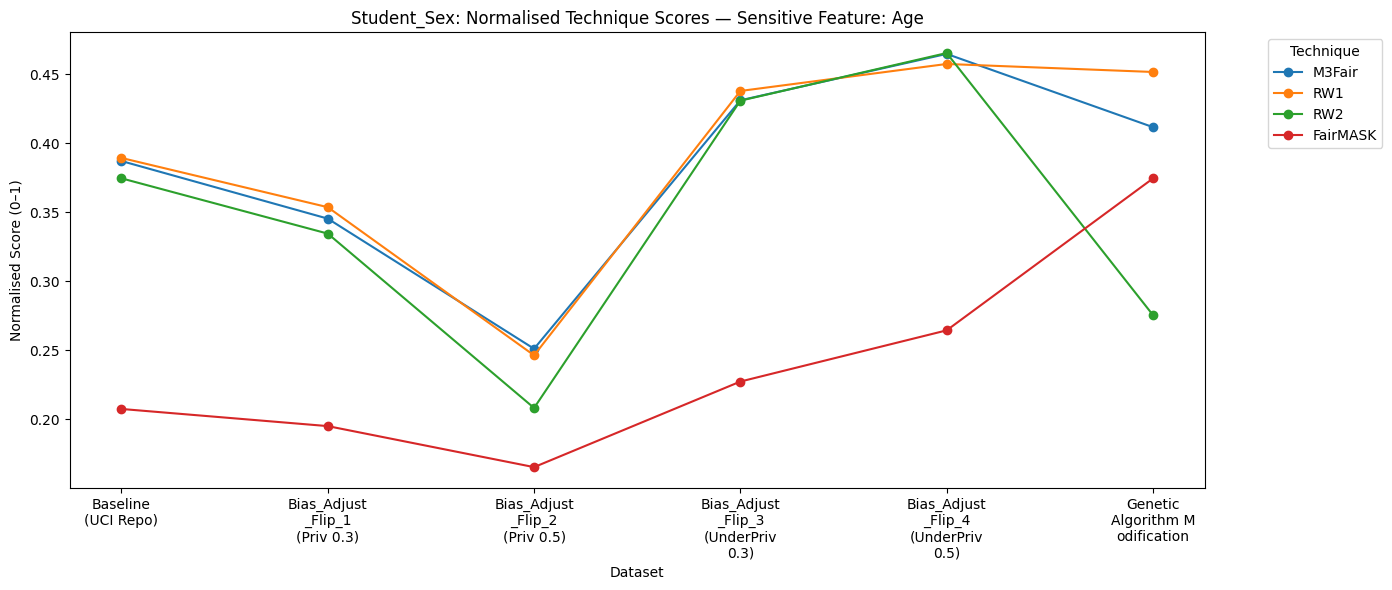

In [ ]:
# Define technique order for Student
technique_order = ["M3Fair", "RW1", "RW2", "FairMASK"]

student_multi_delta_df = compute_deltas(stu_multi_df, metrics)
plot_individual_deltas(student_multi_delta_df, technique_order, metrics)
plot_combined_scores("Student_Sex", student_multi_delta_df, technique_order)

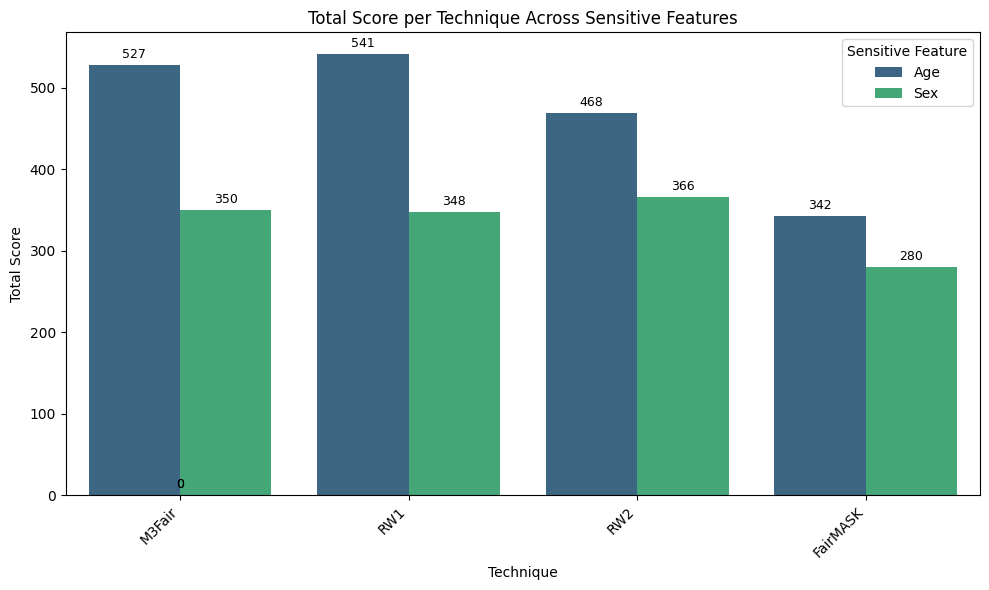

In [ ]:
versions_to_exclude = [
    "Bias_Boundary_Flip_1 (Priv)",
    "Bias_Boundary_Flip_2 (UnderPriv)"
    ]

student_multi_total_sex = plot_filtered_scores(student_multi_delta_df, versions_to_exclude, technique_order)

# Student Multi-Feature - Datasets Modified for Age

In [ ]:
# Step 1: Load the first 2 rows (the headers)
df_headers = pd.read_csv('/content/drive/MyDrive/UCL_MSc_AI/UCLFinalProj/FinalProj_Main/Results/ResultsComp_Multi_StuAge.csv', nrows=2, header=None)

# Step 2: Concatenate the two rows column-wise to create a new header
new_header = df_headers.iloc[0].astype(str) + " " + df_headers.iloc[1].astype(str)

# Step 3: Load the rest of the data, skipping the first two rows and applying the new header
stuage_multi_df = pd.read_csv('/content/drive/MyDrive/UCL_MSc_AI/UCLFinalProj/FinalProj_Main/Results/ResultsComp_Multi_StuAge.csv', skiprows=2, header=None)
stuage_multi_df.columns = new_header

# Drop the 'nan' from the column headers
stuage_multi_df.columns = stuage_multi_df.columns.str.replace('nan ', '', regex=False)

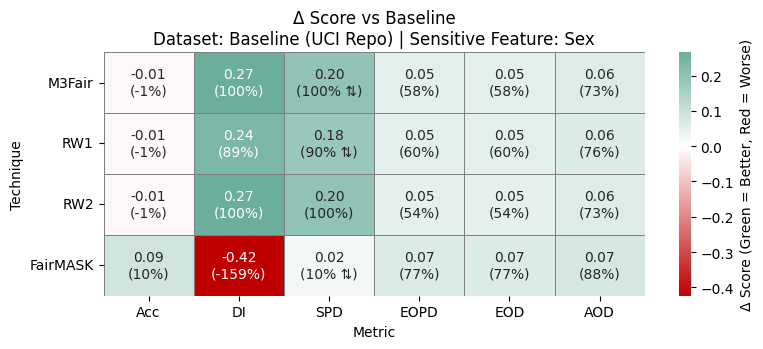

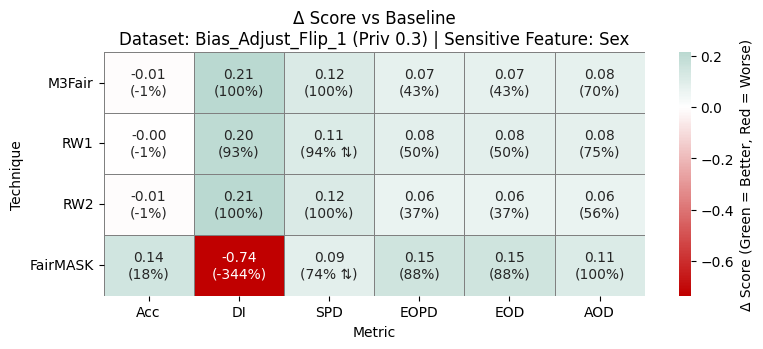

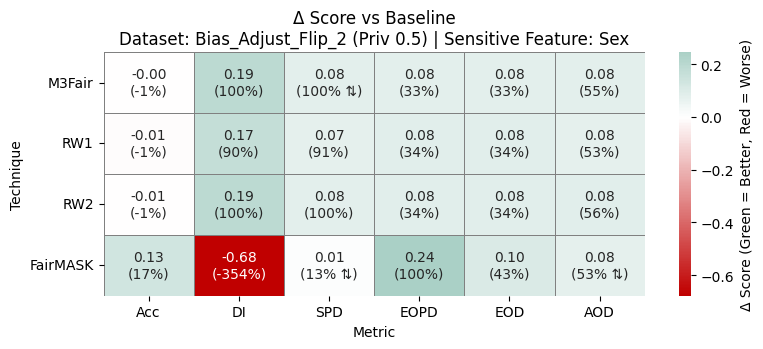

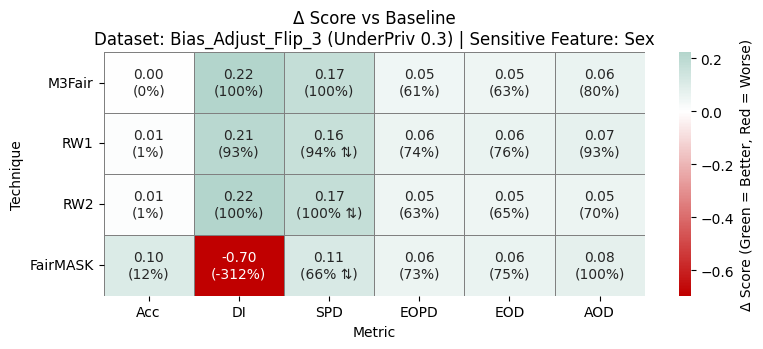

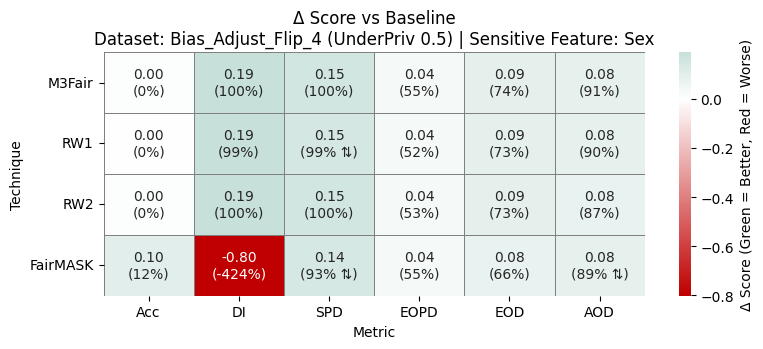

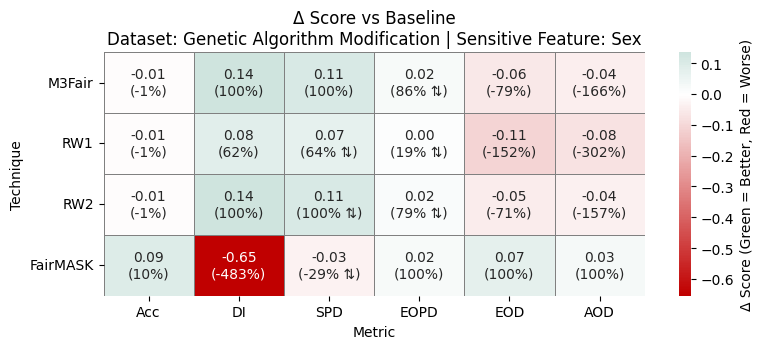

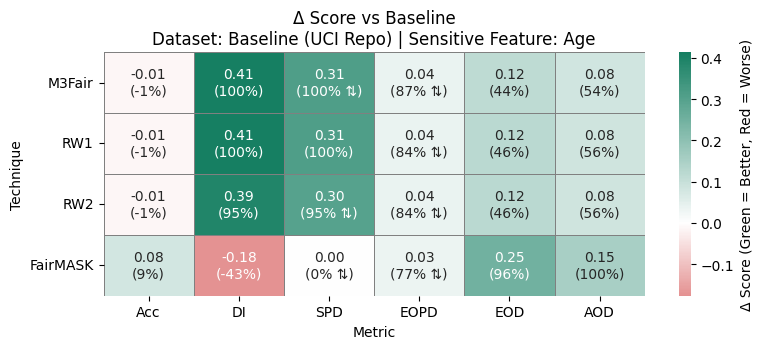

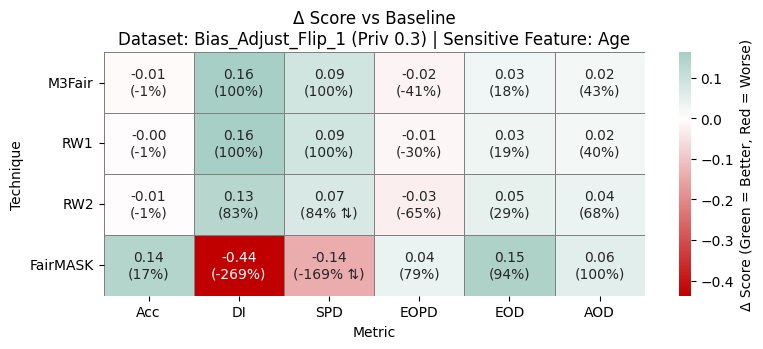

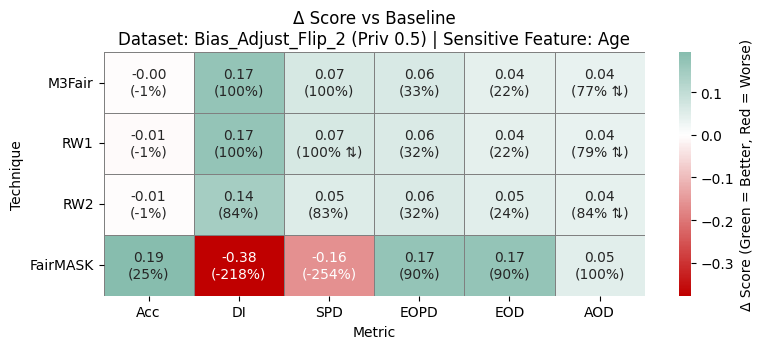

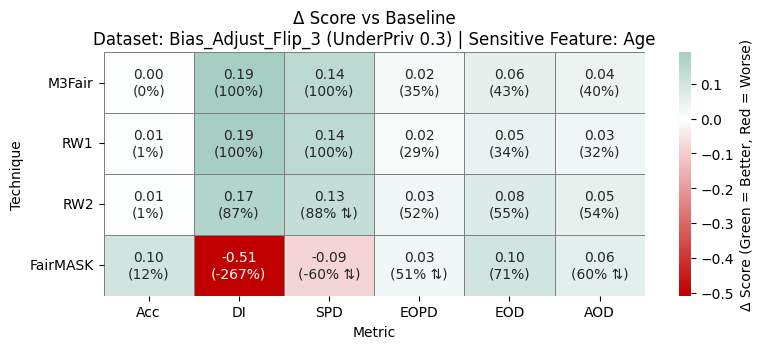

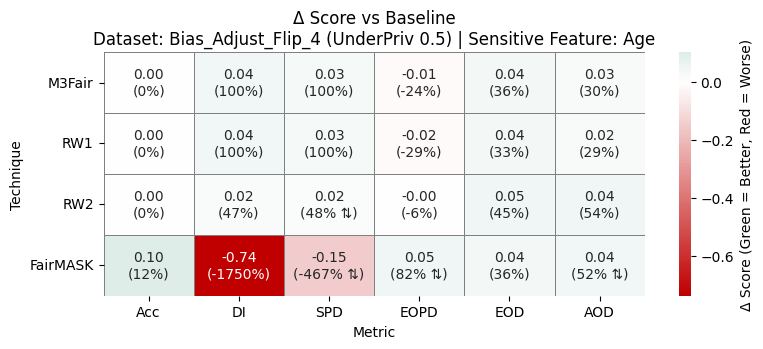

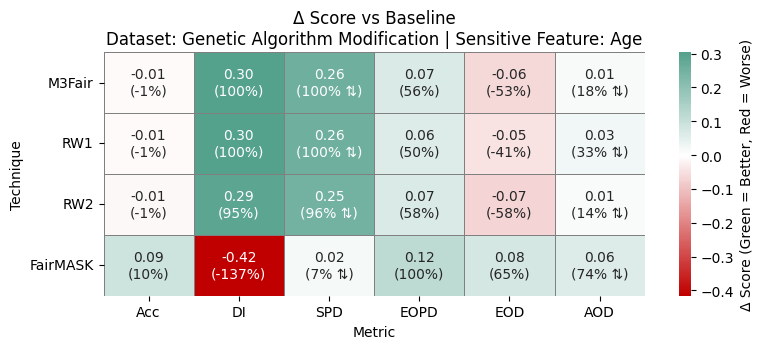

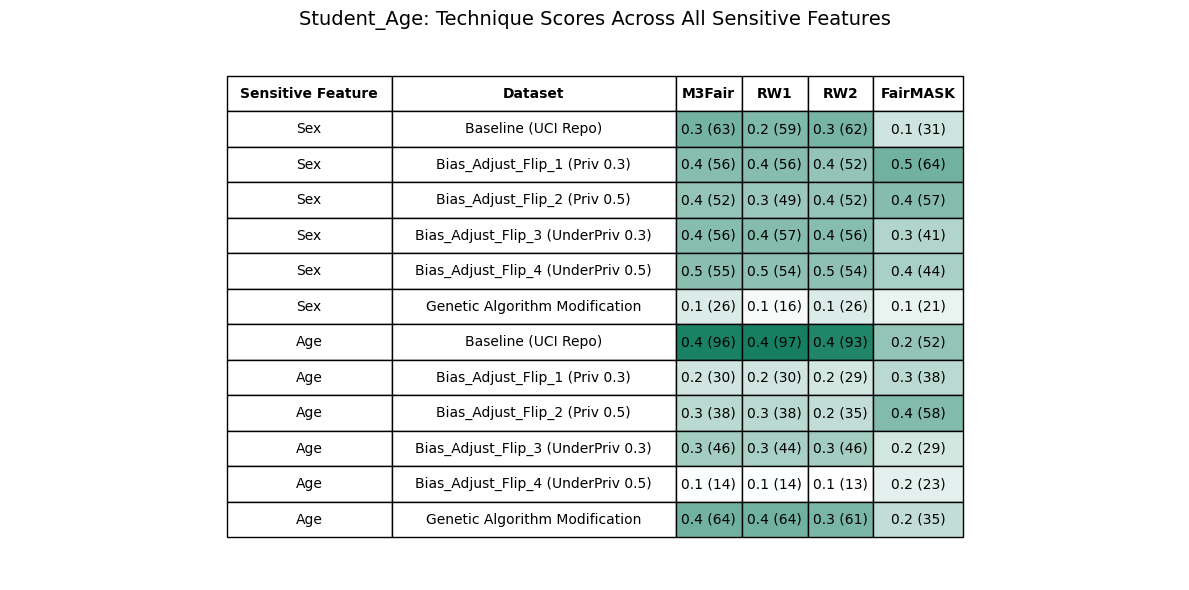

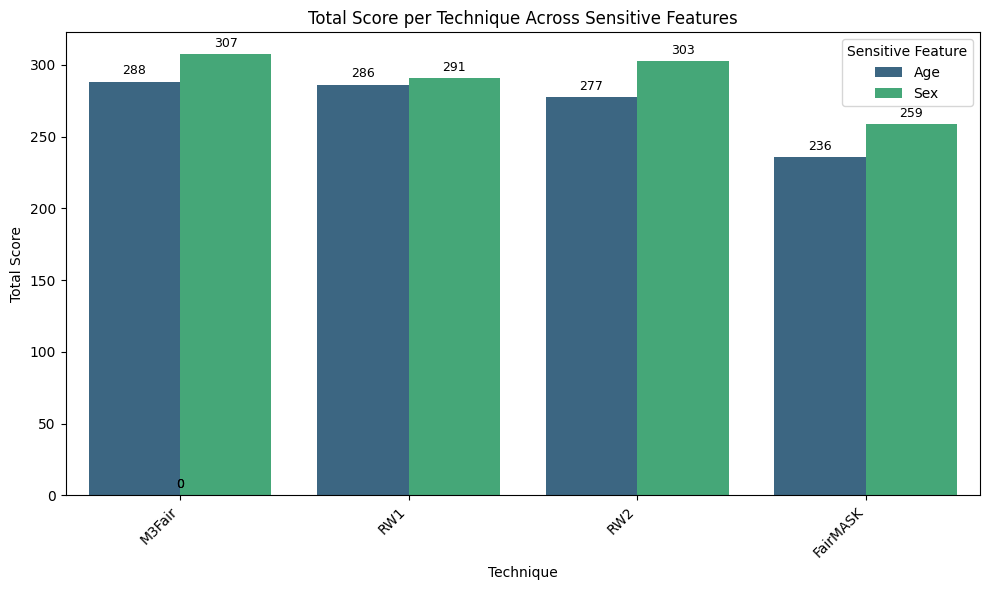

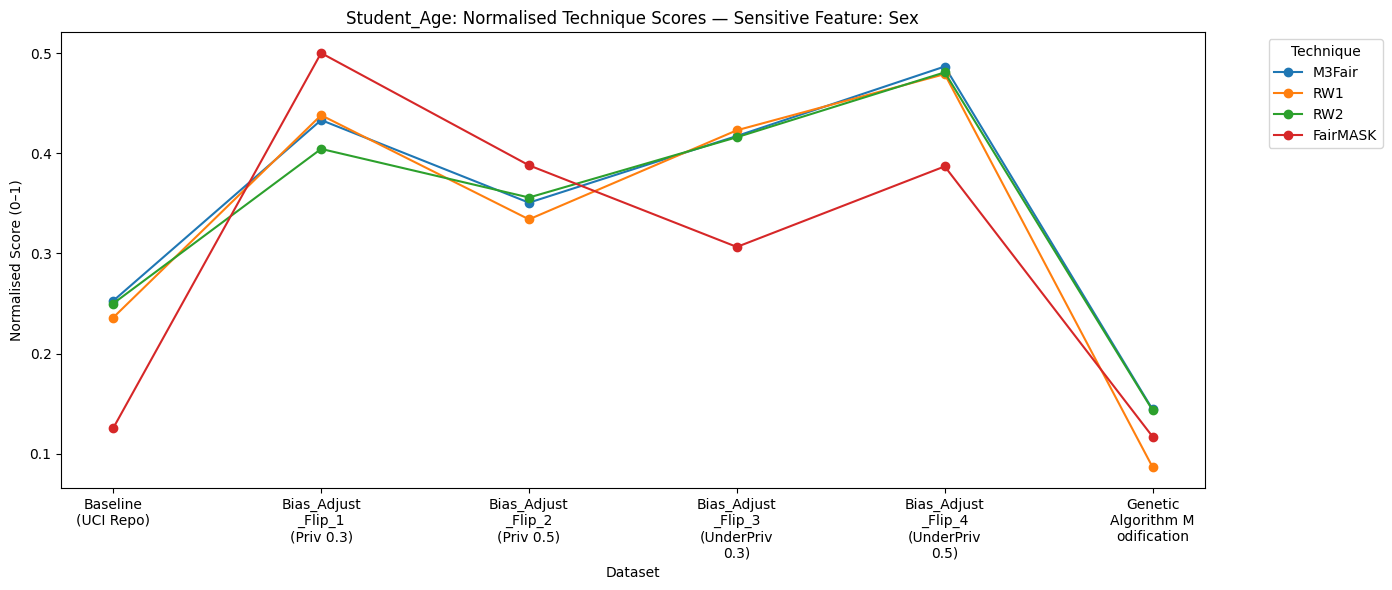

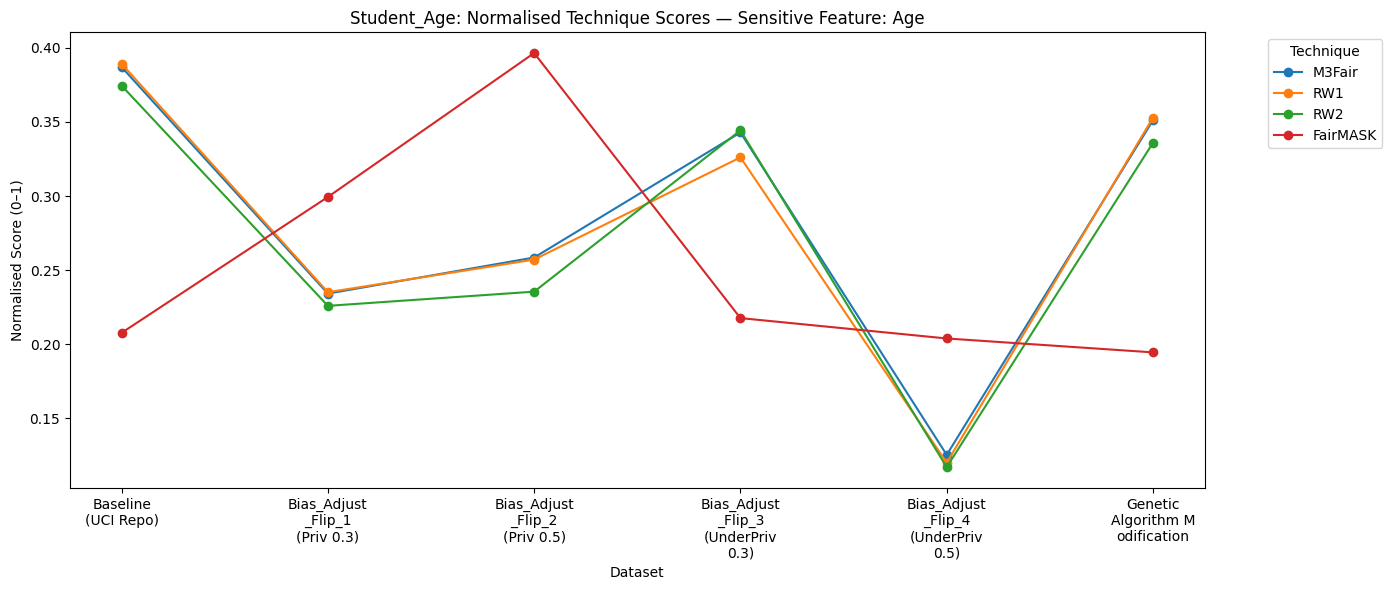

In [ ]:
# Define technique order for Student
technique_order = ["M3Fair", "RW1", "RW2", "FairMASK"]

studentage_multi_delta_df = compute_deltas(stuage_multi_df, metrics)
plot_individual_deltas(studentage_multi_delta_df, technique_order, metrics)
plot_combined_scores("Student_Age", studentage_multi_delta_df, technique_order)

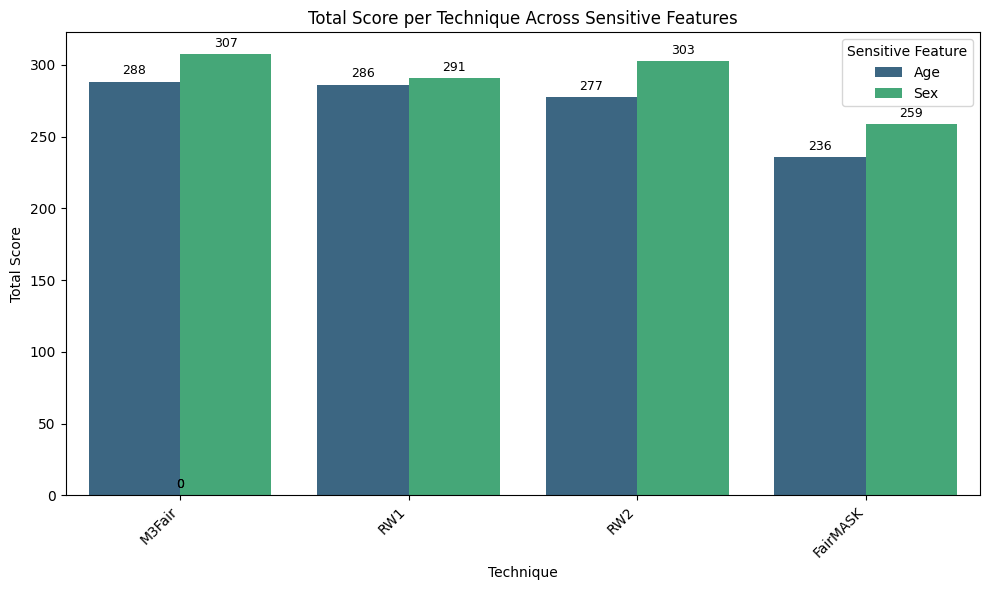

In [ ]:
versions_to_exclude = [
    "Bias_Boundary_Flip_1 (Priv)",
    "Bias_Boundary_Flip_2 (UnderPriv)"
    ]

student_multi_total_age = plot_filtered_scores(studentage_multi_delta_df, versions_to_exclude, technique_order)

#Summary for Intersectional Analysis

In [ ]:
# Add a column to identify the dataset
adult_multi_total_sex["Dataset"] = "Adult_Sex"
adult_multi_total_race["Dataset"] = "Adult_Race"
german_multi_total_sex["Dataset"] = "German_Sex"
german_multi_total_age["Dataset"] = "German_Age"
student_multi_total_sex["Dataset"] = "Student_Sex"
student_multi_total_age["Dataset"] = "Student_Age"

# Combine all tables
combined_df = pd.concat([adult_multi_total_sex, adult_multi_total_race, german_multi_total_sex, german_multi_total_age, student_multi_total_sex, student_multi_total_age], ignore_index=True)

# Pivot the table: rows = Dataset + Sensitive Feature, columns = Technique, values = Score
combined_pivot = combined_df.pivot_table(
    index=["Dataset", "Sensitive Feature"],
    columns="Technique",
    values="Score"
)

# Optional: reset index so Dataset and Sensitive Feature are columns
combined_pivot = combined_pivot.reset_index()

# Reorder techniques if needed
technique_order = ["M3Fair", "RW1", "RW2","FairMASK", "FairC"]
combined_pivot = combined_pivot[['Dataset', 'Sensitive Feature'] + [t for t in technique_order if t in combined_pivot.columns]]

# Display the combined table
combined_pivot

Technique      Dataset Sensitive Feature       M3Fair         RW1  \
0           Adult_Race              Race   557.966308  551.539133   
1           Adult_Race               Sex  1009.619834  956.908474   
2            Adult_Sex              Race   483.092920  485.263949   
3            Adult_Sex               Sex   955.947312  939.297640   
4           German_Age               Age   263.488751  246.450005   
5           German_Age               Sex    89.878227   72.099453   
6           German_Sex               Age   319.773761  334.544562   
7           German_Sex               Sex   390.823193  340.480081   
8          Student_Age               Age   288.335434  286.260458   
9          Student_Age               Sex   307.274132  290.691859   
10         Student_Sex               Age   527.252480  540.616278   
11         Student_Sex               Sex   349.903408  347.780558   

Technique          RW2    FairMASK       FairC  
0           434.082198         NaN  201.158999  
1          1008.717101         NaN  636.150810  
2           385.969610         NaN  266.151088  
3           955.334767         NaN  531.565897  
4           244.647933         NaN  146.429973  
5            91.128242         NaN   95.594965  
6           277.306120         NaN  156.763147  
7           400.096853         NaN  222.944264  
8           277.251032  235.972721         NaN  
9           302.686090  258.703106         NaN  
10          468.389490  342.152644         NaN  
11          365.767488  280.193801         NaN

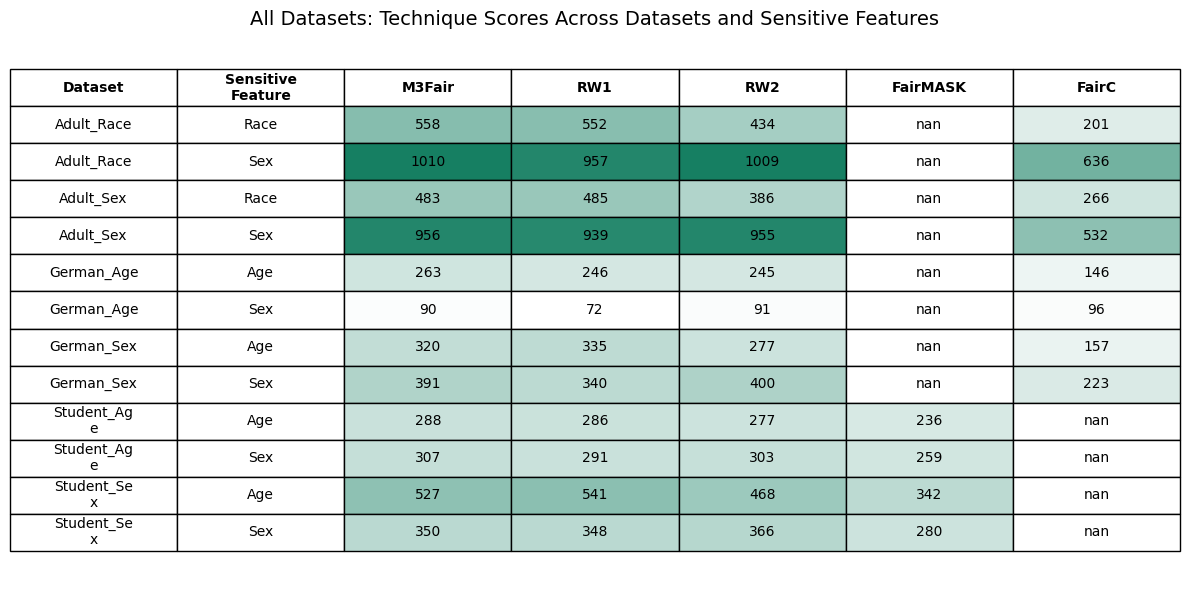

In [ ]:
plot_combined_results_table(combined_pivot, technique_order, name="All Datasets")

# Reference Figure Plot

In [ ]:
ref = pd.read_csv('/content/drive/MyDrive/UCL_MSc_AI/UCLFinalProj/FinalProj_Main/Results/ReferenceFigures.csv')

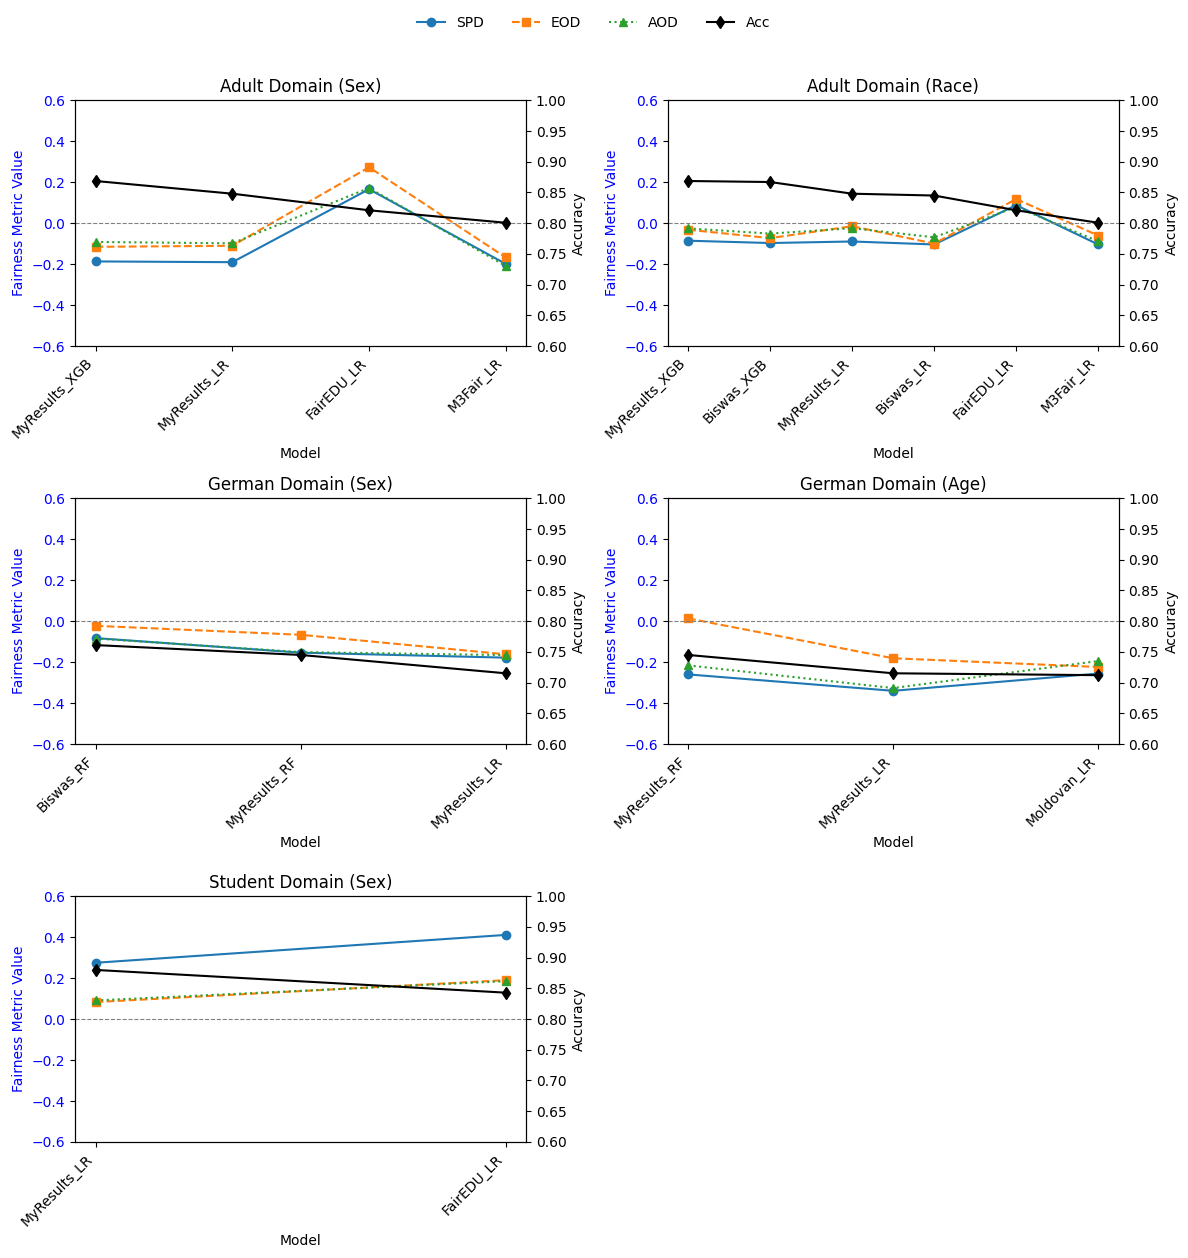

In [ ]:
# Get unique combinations of 'Domain' and 'Sensitive'
unique_pairs = ref[['Domain', 'Sensitive']].drop_duplicates().reset_index(drop=True)

# Number of plots
n = len(unique_pairs)

# Create grid: 2 columns, enough rows to fit all plots
ncols = 2
nrows = int(np.ceil(n / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 4 * nrows))
axes = axes.flatten()  # flatten to easily index

for idx, row in unique_pairs.iterrows():
    domain = row['Domain']
    sensitive = row['Sensitive']

    # Filter data
    df_filtered = ref[(ref['Domain'] == domain) & (ref['Sensitive'] == sensitive)].copy()
    df_plot = df_filtered[['Model.1', 'Acc', 'SPD', 'EOD', 'AOD']]
    df_plot_sorted = df_plot.sort_values(by='Acc', ascending=False)

    models = df_plot_sorted['Model.1'].tolist()
    x = np.arange(len(models))

    # Axes for this subplot
    ax1 = axes[idx]
    ax2 = ax1.twinx()

    # Fairness metrics
    ax1.set_ylabel('Fairness Metric Value', color='blue')
    ax1.plot(x, df_plot_sorted['SPD'], marker='o', linestyle='-', color='#1f77b4', label='SPD')
    ax1.plot(x, df_plot_sorted['EOD'], marker='s', linestyle='--', color='#ff7f0e', label='EOD')
    ax1.plot(x, df_plot_sorted['AOD'], marker='^', linestyle=':', color='#2ca02c', label='AOD')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.axhline(0, color='grey', linestyle='--', linewidth=0.8)
    ax1.set_ylim(-0.6, 0.6)

    # Accuracy
    ax2.set_ylabel('Accuracy', color='black')
    ax2.plot(x, df_plot_sorted['Acc'], marker='d', linestyle='-', color='black', label='Acc')
    ax2.tick_params(axis='y', labelcolor='black')
    ax2.set_ylim(0.6, 1.0)

    # Labels
    ax1.set_xlabel('Model')
    ax1.set_xticks(x)
    ax1.set_xticklabels(models, rotation=45, ha='right')

    ax1.set_title(f'{domain} Domain ({sensitive})')

    # Legend outside (only for the first subplot to avoid duplicates)
    if idx == 0:
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        fig.legend(lines1 + lines2, labels1 + labels2,
                   loc='upper center', bbox_to_anchor=(0.5, 1.05),
                   ncol=4, frameon=False)

# Remove empty subplots if n is odd
for j in range(idx+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Old Codes

In [ ]:
def plot_final_scores_wo(name, delta_df, technique_order):
    # Apply scoring
    delta_df["Score"] = delta_df.apply(score_row, axis=1)

    # 🔹 Exclude F1 and ROC for bar + line plots
    filtered_df = delta_df[~delta_df["Metric"].isin(["F1", "ROC"])].copy()

    # Normalised score (row-wise, per dataset)
    delta_df["Norm_Score"] = delta_df.groupby("Data")["Score"].transform(
        lambda x: (x - x.min()) / (x.max() - x.min()) if x.max() != x.min() else 0
    )

    # Normalised score (row-wise, per dataset, for filtered metrics)
    filtered_df["Norm_Score"] = filtered_df.groupby("Data")["Score"].transform(
        lambda x: (x - x.min()) / (x.max() - x.min()) if x.max() != x.min() else 0
    )

    # Total score for each Technique, separated by Sensitive Feature based on filtered_df
    total_scores_by_sensitive_feature = filtered_df.groupby(["Sensitive Feature", "Technique"])["Score"].sum().reset_index()

    # Create the light green color map
    green_cmap = LinearSegmentedColormap.from_list("green_white", ["white", "#167F62"])

    # Loop through each sensitive feature
    for sens_feat in delta_df["Sensitive Feature"].unique():
        # Filter and aggregate scores
        filtered = delta_df[delta_df["Sensitive Feature"] == sens_feat]

        score_df = (
            filtered.groupby(["Data", "Technique"], as_index=False)
            .agg({"Score": "sum", "Norm_Score": "mean"})
        )

        # Pivot for heatmap
        score_matrix = score_df.pivot(index="Data", columns="Technique", values="Score")
        norm_matrix = score_df.pivot(index="Data", columns="Technique", values="Norm_Score")

        # Reorder columns
        score_matrix = score_matrix.reindex(columns=technique_order)
        norm_matrix = norm_matrix.reindex(columns=technique_order)

        # ----- HEATMAP WITH CUSTOM ANNOTATIONS -----
        # Build annotation labels: normalised score (top) + actual score (bottom)
        annot_matrix = np.empty_like(score_matrix, dtype='<U20')

        for i in range(score_matrix.shape[0]):
            for j in range(score_matrix.shape[1]):
                norm_val = norm_matrix.iloc[i, j]
                score_val = score_matrix.iloc[i, j]
                annot_matrix[i, j] = f"{norm_val:.1f}\n{score_val:.0f}"

        # Normalize values for color mapping
        norm = colors.Normalize(vmin=score_matrix.min().min(), vmax=score_matrix.max().max())
        cmap = green_cmap

        # Build a DataFrame for display
        table_df = pd.DataFrame(
            annot_matrix,
            index=score_matrix.index,
            columns=score_matrix.columns
        )

        # Function to apply background color based on score
        def background_color(val, i, j):
            score_val = score_matrix.iloc[i, j]
            rgba = cmap(norm(score_val))
            # Convert RGBA to hex
            return f"background-color: rgba({int(rgba[0]*255)}, {int(rgba[1]*255)}, {int(rgba[2]*255)}, {rgba[3]})"

        # Apply styling
        styled_table = table_df.style.format()
        for i in range(score_matrix.shape[0]):
            for j in range(score_matrix.shape[1]):
                styled_table = styled_table.map(
                    lambda v, i=i, j=j: background_color(v, i, j),
                    subset=pd.IndexSlice[[table_df.index[i]], [table_df.columns[j]]]
                )

        # Display in notebook (Jupyter)
        styled_table.set_table_styles(
            [{'selector': 'td', 'props': [('white-space', 'pre')]}]  # allow line breaks
        ).set_caption(
            f"Technique Scores by Dataset — Sensitive Feature: {sens_feat}"
        )

        display(styled_table)

        # Export style table to png
        filename = f"technique_scores_table_{sens_feat}.png"
        dfi.export(styled_table, filename)

        # ----- BAR CHART OF TOTAL SCORES ------

        # Ensure technique column follows fixed order
        subset_df = total_scores_by_sensitive_feature[total_scores_by_sensitive_feature['Sensitive Feature'] == sens_feat].copy()

        # Ensure technique column follows fixed order
        subset_df["Technique"] = pd.Categorical(
            subset_df["Technique"],
            categories=technique_order,
            ordered=True
        )
        subset_df = subset_df.sort_values("Technique")

        plt.figure(figsize=(8, 5))
        ax = sns.barplot(
            x='Technique',
            y='Score',
            data=subset_df,
            palette='viridis',
            #hue='Technique',
            legend=False
        )

        # Add labels on bars
        for p in ax.patches:
            ax.annotate(
                f'{p.get_height():.0f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom',
                fontsize=9, color='black',
                xytext=(0, 3),
                textcoords='offset points'
            )

        plt.title(f'{name}:Total Score per Technique for Sensitive Feature: {sens_feat}')
        plt.xlabel('Technique')
        plt.ylabel('Total Score')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

        # ----- LINE PLOT OF NORMALISED SCORES -----

        filtered_line = filtered_df[filtered_df["Sensitive Feature"] == sens_feat]

        score_df_line = (
            filtered_line.groupby(["Data", "Technique"], as_index=False)
            .agg({"Score": "sum", "Norm_Score": "mean"})
        )
        plt.figure(figsize=(10, 6))
        for tech in technique_order:
            if tech in score_df_line["Technique"].unique():
                tech_scores = score_df_line[score_df_line["Technique"] == tech]
                plt.plot(
                    tech_scores["Data"],
                    tech_scores["Norm_Score"],
                    marker="o",
                    label=tech,
                )

        plt.title(f"{name}: Normalised Technique Scores Across Datasets\nSensitive Feature: {sens_feat}")
        plt.xlabel("Dataset")
        plt.ylabel("Normalised Score (0–1)")
        plt.xticks(rotation=90)
        plt.legend(title="Technique", bbox_to_anchor=(1.05, 1), loc="upper left")
        plt.tight_layout()
        plt.show()

    return total_scores_by_sensitive_feature

In [ ]:
def plot_final_scores(delta_df, technique_order):
    # Apply scoring
    delta_df["Score"] = delta_df.apply(score_row, axis=1)

    # Normalised score (row-wise, per dataset)
    delta_df["Norm_Score"] = delta_df.groupby("Data")["Score"].transform(
        lambda x: (x - x.min()) / (x.max() - x.min()) if x.max() != x.min() else 0
    )

    # Total score for each Technique, separated by Sensitive Feature
    total_scores_by_sensitive_feature = delta_df.groupby(["Sensitive Feature", "Technique"])["Score"].sum().reset_index()

    # Create the light green color map
    green_cmap = LinearSegmentedColormap.from_list("green_white", ["white", "#167F62"])

    # Loop through each sensitive feature
    for sens_feat in delta_df["Sensitive Feature"].unique():
        # Filter and aggregate scores
        filtered = delta_df[delta_df["Sensitive Feature"] == sens_feat]

        score_df = (
            filtered.groupby(["Data", "Technique"], as_index=False)
            .agg({"Score": "sum", "Norm_Score": "mean"})
        )

        # Pivot for heatmap
        score_matrix = score_df.pivot(index="Data", columns="Technique", values="Score")
        norm_matrix = score_df.pivot(index="Data", columns="Technique", values="Norm_Score")

        # Reorder columns
        score_matrix = score_matrix.reindex(columns=technique_order)
        norm_matrix = norm_matrix.reindex(columns=technique_order)

        # ----- HEATMAP WITH CUSTOM ANNOTATIONS -----
        # Build annotation labels: normalised score (top) + actual score (bottom)
        annot_matrix = np.empty_like(score_matrix, dtype='<U20')

        for i in range(score_matrix.shape[0]):
            for j in range(score_matrix.shape[1]):
                norm_val = norm_matrix.iloc[i, j]
                score_val = score_matrix.iloc[i, j]
                # Use f-strings for precise formatting: 1 decimal for normalized, 0 for score
                annot_matrix[i, j] = f"{norm_val:.1f}\n{score_val:.0f}"

        plt.figure(figsize=(12, len(score_matrix) * 0.5 + 2))
        sns.heatmap(
            score_matrix,
            annot=annot_matrix,
            fmt="",
            cmap=green_cmap,
            linewidths=0.5,
            linecolor="grey",
            cbar_kws={"label": "Total Score (↑ Better)"},
        )

        plt.title(f"Technique Scores by Dataset\nSensitive Feature: {sens_feat}")
        plt.xlabel("Technique")
        plt.ylabel("Dataset")
        plt.xticks(rotation=90)
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

        # ----- BAR CHART OF TOTAL SCORES ------
        subset_df = total_scores_by_sensitive_feature[total_scores_by_sensitive_feature['Sensitive Feature'] == sens_feat].copy()

        # Ensure technique column follows fixed order
        subset_df["Technique"] = pd.Categorical(
            subset_df["Technique"],
            categories=technique_order,
            ordered=True
        )
        subset_df = subset_df.sort_values("Technique")

        plt.figure(figsize=(8, 5))
        ax = sns.barplot(
            x='Technique',
            y='Score',
            data=subset_df,
            palette='viridis',
            #hue='Technique',
            legend=False
        )

        # Add labels on bars
        for p in ax.patches:
            ax.annotate(
                f'{p.get_height():.0f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom',
                fontsize=9, color='black',
                xytext=(0, 3),
                textcoords='offset points'
            )

        plt.title(f'Total Score per Technique for Sensitive Feature: {sens_feat}')
        plt.xlabel('Technique')
        plt.ylabel('Total Score')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

        # ----- LINE PLOT OF NORMALISED SCORES -----
        plt.figure(figsize=(10, 6))
        for tech in technique_order:
            if tech in score_df["Technique"].unique():
                tech_scores = score_df[score_df["Technique"] == tech]
                plt.plot(
                    tech_scores["Data"],
                    tech_scores["Norm_Score"],
                    marker="o",
                    label=tech,
                )

        plt.title(f"Normalised Technique Scores Across Datasets\nSensitive Feature: {sens_feat}")
        plt.xlabel("Dataset")
        plt.ylabel("Normalised Score (0–1)")
        plt.xticks(rotation=90)
        plt.legend(title="Technique", bbox_to_anchor=(1.05, 1), loc="upper left")
        plt.tight_layout()
        plt.show()

    return total_scores_by_sensitive_feature

In [ ]:
def plot_final_scores(name, delta_df, technique_order):
    # Apply scoring
    delta_df["Score"] = delta_df.apply(score_row, axis=1)

    # 🔹 Exclude F1 and ROC for bar + line plots
    filtered_df = delta_df[~delta_df["Metric"].isin(["F1", "ROC"])].copy()

    # Normalised score (row-wise, per dataset)
    delta_df["Norm_Score"] = delta_df.groupby("Data")["Score"].transform(
        lambda x: (x - x.min()) / (x.max() - x.min()) if x.max() != x.min() else 0
    )

    # Normalised score (row-wise, per dataset, for filtered metrics)
    filtered_df["Norm_Score"] = filtered_df.groupby("Data")["Score"].transform(
        lambda x: (x - x.min()) / (x.max() - x.min()) if x.max() != x.min() else 0
    )

    # Total score for each Technique, separated by Sensitive Feature based on filtered_df
    total_scores_by_sensitive_feature = filtered_df.groupby(["Sensitive Feature", "Technique"])["Score"].sum().reset_index()

    # Create the light green color map
    green_cmap = LinearSegmentedColormap.from_list("green_white", ["white", "#167F62"])

    # Loop through each sensitive feature
    for sens_feat in delta_df["Sensitive Feature"].unique():
        # Filter and aggregate scores
        filtered = delta_df[delta_df["Sensitive Feature"] == sens_feat]

        score_df = (
            filtered.groupby(["Data", "Technique"], as_index=False)
            .agg({"Score": "sum", "Norm_Score": "mean"})
        )

        # Pivot for heatmap
        score_matrix = score_df.pivot(index="Data", columns="Technique", values="Score")
        norm_matrix = score_df.pivot(index="Data", columns="Technique", values="Norm_Score")

        # Reorder columns
        score_matrix = score_matrix.reindex(columns=technique_order)
        norm_matrix = norm_matrix.reindex(columns=technique_order)

        # ----- MATPLOTLIB TABLE CREATION AND EXPORT WITH COLOR CODING -----

        # Build annotation labels
        annot_matrix = np.empty_like(score_matrix, dtype='<U20')
        for i in range(score_matrix.shape[0]):
            for j in range(score_matrix.shape[1]):
                norm_val = norm_matrix.iloc[i, j]
                score_val = score_matrix.iloc[i, j]
                annot_matrix[i, j] = f"{norm_val:.1f} ({score_val:.0f})"

        # Create a Matplotlib figure and axis
        fig, ax = plt.subplots(figsize=(10, len(score_matrix.index) * 0.5 + 1))
        ax.axis('off')  # Hide axes

        # Create the table
        table = ax.table(
            cellText=annot_matrix,
            colLabels=score_matrix.columns,
            rowLabels=score_matrix.index,
            loc='center',
            cellLoc='center'
        )

        # Manually apply colors to each cell
        norm = Normalize(vmin=score_matrix.min().min(), vmax=score_matrix.max().max())

        # Use nested loops with explicit indices to match the data matrix dimensions
        for i in range(score_matrix.shape[0]):
            for j in range(score_matrix.shape[1]):
                # Get the cell object from the table
                # Add 1 to row index to skip the column header
                cell = table.get_celld()[(i + 1, j)]

                # Get the score value
                score_val = score_matrix.iloc[i, j]

                # Get the color from the colormap
                color = green_cmap(norm(score_val))

                # Set the background color of the cell
                cell.set_facecolor(color)

        # Apply a title to the table
        ax.set_title(f"Technique Scores by Dataset — Sensitive Feature: {sens_feat}", fontsize=14, pad=20)

        # Scale the table font and size for better readability
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1.2, 1.2)

        # Display Save the figure to a high-quality PNG
        filename = f"{name}_technique_scores_table_{sens_feat}.png"
        plt.savefig(filename, bbox_inches='tight', dpi=300)
        plt.close(fig)

        display(pd.DataFrame(annot_matrix, index=score_matrix.index, columns=score_matrix.columns))
        print(f"Table saved to {filename}")

        # ----- BAR CHART OF TOTAL SCORES ------

        # Ensure technique column follows fixed order
        subset_df = total_scores_by_sensitive_feature[total_scores_by_sensitive_feature['Sensitive Feature'] == sens_feat].copy()

        # Ensure technique column follows fixed order
        subset_df["Technique"] = pd.Categorical(
            subset_df["Technique"],
            categories=technique_order,
            ordered=True
        )
        subset_df = subset_df.sort_values("Technique")

        plt.figure(figsize=(8, 5))
        ax = sns.barplot(
            x='Technique',
            y='Score',
            data=subset_df,
            palette='viridis',
            #hue='Technique',
            legend=False
        )

        # Add labels on bars
        for p in ax.patches:
            ax.annotate(
                f'{p.get_height():.0f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom',
                fontsize=9, color='black',
                xytext=(0, 3),
                textcoords='offset points'
            )

        plt.title(f'{name}:Total Score per Technique for Sensitive Feature: {sens_feat}')
        plt.xlabel('Technique')
        plt.ylabel('Total Score')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

        # ----- LINE PLOT OF NORMALISED SCORES -----

        filtered_line = filtered_df[filtered_df["Sensitive Feature"] == sens_feat]

        score_df_line = (
            filtered_line.groupby(["Data", "Technique"], as_index=False)
            .agg({"Score": "sum", "Norm_Score": "mean"})
        )
        plt.figure(figsize=(10, 6))
        for tech in technique_order:
            if tech in score_df_line["Technique"].unique():
                tech_scores = score_df_line[score_df_line["Technique"] == tech]
                plt.plot(
                    tech_scores["Data"],
                    tech_scores["Norm_Score"],
                    marker="o",
                    label=tech,
                )

        plt.title(f"{name}: Normalised Technique Scores Across Datasets\nSensitive Feature: {sens_feat}")
        plt.xlabel("Dataset")
        plt.ylabel("Normalised Score (0–1)")
        plt.xticks(rotation=90)
        plt.legend(title="Technique", bbox_to_anchor=(1.05, 1), loc="upper left")
        plt.tight_layout()
        plt.show()

    return total_scores_by_sensitive_feature